# Mini Project 2 - Machine Learning in Practice

# Chủ đề: Classification/Cardiovascular Disease

## Nhóm thực hiện: Nhóm 3
- Tô Minh Đức - B21DCDT068
- Nguyễn Minh Đăng - B21DCVT103
- Nguyễn Trường Giang - B21DCVT168
- Nguyễn Văn Thi - B21DCCN685
- Nguyễn Thị Thu Trang - 22028254

# Cài đặt, import các thư viện và dataset

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    roc_curve
)
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_data(filepath):
    try: 
        df = pd.read_csv(filepath, delimiter=';')
        print("Đọc dữ liệu thành công")
        return df
    except FileNotFoundError:
            print("File không tồn tại")
    except pd.errors.ParserError:
            print("Lỗi định dạng file")
    return None

df = load_data("/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv") 

Đọc dữ liệu thành công


# I. Exploratory Data Analysis

## 1. Giới thiệu và lựa chọn dữ liệu

### Nguồn gốc của tập dữ liệu:
* Bộ dữ liệu được lấy từ Kaggle.
* Đây là tập dữ liệu mở, phổ biến cho các bài toán dự đoán bệnh tim mạch.

### Mô tả chung về bộ dữ liệu:
Bộ dữ liệu Cardiovascular Disease Dataset bao gồm 70.000 mẫu dữ liệu bệnh nhân, được sử dụng để nghiên cứu mối liên hệ giữa các yếu tố sức khỏe và khả năng mắc bệnh tim mạch. Dữ liệu có nhãn (cardio) cho biết người đó có bị bệnh tim mạch hay không, phù hợp cho bài toán phân loại nhị phân trong học máy.

### Khám phá tổng quan

In [5]:
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.shape

(70000, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
df.duplicated().sum()

0

In [6]:
df.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

In [6]:
columns = list(df.columns)
categorical_cols = []
numerical_cols = []
for i in columns:
    if len(df[i].unique()) > 5:
        numerical_cols.append(i)
    else:
        categorical_cols.append(i)     
print('Numerical features: ', numerical_cols)
print('Categorical features: ', categorical_cols)

Numerical features:  ['id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo']
Categorical features:  ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


### Thông tin Dataset

#### Dataset gồm **13 cột**, chi tiết như sau:

| Tên cột       | Ý nghĩa                                                                 | Đơn vị       | Kiểu dữ liệu | Dạng dữ liệu   |
|---------------|-------------------------------------------------------------------------|--------------|---------------|----------------|
| `id`          | Định danh duy nhất cho mỗi bệnh nhân                                    | -            | Số nguyên     | Danh mục (ID)  |
| `age`         | Tuổi của bệnh nhân (tính theo ngày)                                     | Ngày         | Số nguyên     | Số (numerical) |
| `gender`      | Giới tính của bệnh nhân: `1 = Nữ`, `2 = Nam`                            | -            | Số nguyên     | Danh mục (categorical) |
| `height`      | Chiều cao bệnh nhân                                                     | cm           | Số nguyên     | Số (numerical) |
| `weight`      | Cân nặng bệnh nhân                                                      | kg           | Số thực       | Số (numerical) |
| `ap_hi`       | Huyết áp tâm thu                                                        | mmHg         | Số nguyên     | Số (numerical) |
| `ap_lo`       | Huyết áp tâm trương                                                     | mmHg         | Số nguyên     | Số (numerical) |
| `cholesterol` | Mức cholesterol trong máu: `1 = Bình thường`, `2 = Cao`, `3 = Rất cao` | -            | Số nguyên     | Danh mục thứ bậc (ordinal) |
| `gluc`        | Mức glucose trong máu: `1 = Bình thường`, `2 = Cao`, `3 = Rất cao`     | -            | Số nguyên     | Danh mục thứ bậc (ordinal) |
| `smoke`       | Có hút thuốc không: `0 = Không`, `1 = Có`                               | -            | Số nguyên     | Nhị phân (binary) |
| `alco`        | Có uống rượu không: `0 = Không`, `1 = Có`                               | -            | Số nguyên     | Nhị phân (binary) |
| `active`      | Có vận động thể chất không: `0 = Không`, `1 = Có`                       | -            | Số nguyên     | Nhị phân (binary) |
| `cardio`      | **Nhãn (label)**: Bệnh nhân có mắc bệnh tim mạch không: `0 = Không`, `1 = Có` | -     | Số nguyên     | Nhị phân (binary) |



#### Các đặc trưng quan trọng: 
* Ngoại trừ cột định danh `id` và biến mục tiêu `cardio`, toàn bộ các đặc trưng còn lại bao gồm:`age`, `gender`, `height`, `weight`, `ap_hi`, `ap_lo`, `cholesterol`, `gluc`, `smoke`, `alco`, `active` đều đóng vai trò quan trọng trong quá trình phân tích khám phá dữ liệu (EDA), vì chúng phản ánh các yếu tố sức khỏe và lối sống liên quan trực tiếp đến nguy cơ mắc bệnh tim mạch.

## 2. Thực hiện thống kê mô tả

### 2.1. Thống kê trên các dữ liệu dạng categorical

In [7]:
numerical_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [8]:
def print_categorical_summary(df, col):
    counts = df[col].value_counts()
    percents = df[col].value_counts(normalize=True) * 100

    summary = pd.DataFrame({
        'Số lượng': counts.values,
        'Tỷ lệ (%)': percents.round(2)
    })

    return summary

In [9]:
for col in categorical_cols:
    print(f"\nCột: {col}")
    temp = print_categorical_summary(df, col)
    display(temp)


Cột: gender


,Số lượng,Tỷ lệ (%)
gender,,
1,45530,65.04
2,24470,34.96



Cột: cholesterol


,Số lượng,Tỷ lệ (%)
cholesterol,,
1,52385,74.84
2,9549,13.64
3,8066,11.52



Cột: gluc


,Số lượng,Tỷ lệ (%)
gluc,,
1,59479,84.97
3,5331,7.62
2,5190,7.41



Cột: smoke


,Số lượng,Tỷ lệ (%)
smoke,,
0,63831,91.19
1,6169,8.81



Cột: alco


,Số lượng,Tỷ lệ (%)
alco,,
0,66236,94.62
1,3764,5.38



Cột: active


,Số lượng,Tỷ lệ (%)
active,,
1,56261,80.37
0,13739,19.63


##### Nhận xét
1. Cột gender (Giới tính)
* Số lượng nữ: 45530.
* Số lượng nam: 24470
* Nhận xét: Tỷ lệ nữ cao hơn đáng kể, có thể gây lệch phân bố dữ liệu đầu vào.(Khoảng 65% nữ vs. 35% nam).
* Đề xuất: Cân nhắc sử dụng mô hình phân tích nhạy với phân bố lệch.
  
2. Cột cholesterol(Mức cholesterol trong máu):
* Khoảng 74.85% bệnh nhân có mức cholesterol bình thường.
* Khoảng 13.64% bệnh nhân có mức cholesterol cao.
* Tỷ lệ bệnh nhân có mức cholesterol rất cao chiếm phần còn lại.
* Nhận xét: Bệnh nhân có mức cholesterol cao hoặc rất cao có nguy cơ mắc bệnh tim mạch cao hơn đáng kể so với nhóm bình thường.
  
3. Cột glu (Mức glucose)
* Phần lớn bệnh nhân có mức glucose bình thường( chiếm 84.97%)
* 15.03% bệnh nhân có mức glucose trên bình thường hoặc cao.
* Nhận xét: Bệnh nhân có glucose bình thường đa phần cũng có cholesterol bình thường (70%). Tuy nhiên, nhóm có glucose cao và rất cao hơn có nguy cơ mắc bệnh tim mạch cao hơn
  
4. Cột smoke (Hút thuốc)
* Tỉ lệ bệnh nhân hút thuốc chiếm phần nhỏ chưa đến 10%.
* Nhận xét: Tỷ lệ hút thuốc thấp hơn so với thực tế dân số, có thể do dữ liệu bị thiên lệch (bias) hoặc khai báo không đầy đủ. Tỷ lệ mắc bệnh tim mạch ở nhóm hút thuốc cao hơn so với nhóm không hút thuốc.
  
5. Cột alco (Uống rượu)
* Khoảng 5% bệnh nhân uống rượu.
* Nhận xét: Tương tự như hút thuốc, tỷ lệ uống rượu thấp hơn so với thực tế. Tỷ lệ mắc bệnh tim mạch ở nhóm uống rượu cao hơn so với nhóm không uống rượu.
  
6. Cột active(Hoạt động thể chất)
* Tỉ lệ người tham gia hoạt động thể chất cao chiếm 80%.
* Nhận xét: Tỷ lệ mắc bệnh tim mạch ở nhóm không hoạt động thể chất cao hơn so với nhóm có hoạt động thể chất. Đây là yếu tố sức khỏe quan trọng cần đưa vào mô hình dự đoán.


### 2.2. Thống kê trên các dữ liệu dạng numerical

In [11]:
df[numerical_cols].describe()

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414
std,2467.251667,8.210126,14.395757,154.011419,188.472530
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


##### Nhận xét
1. Cột age (tuổi)
* Đơn vị: ngày.
* Phân bố khá rộng, không có giá trị bất thường rõ ràng.
* Đề xuất: Thêm cột mới age_years đơn vị năm bằng cách chia cho 365.


2. Cột Height (chiều cao)
* Đơn vị: cm
* Trung bình: 164.4 cm.
* Độ lệch chuẩn 8.2 cm.
* Giá trị nhỏ nhất: 55cm.
* Giá trị lớn nhất :250cm.
* Nhận xét: Phân bố hợp lý, giá trị nhỏ nhất và lớn nhất có thể chấp nhận được.

3. Cột weight(cân nặng)
* Đơn vị: kg
* Giá trị nhỏ nhất: 10kg
* Giá trị lớn nhất: 200kg => hiếm
* Nhận xét: Giá trị 10 kg là bất thường, đặc biệt khi tuổi tối thiểu là 29 tuổi; có thể coi là ngoại lệ.
* Đề xuất: Cắt giá trị về khoảng (30, 180) kg để loại bỏ ngoại lệ
* 
Có thể thêm cột BMI(Chỉ số khối cơ thể = weight/(height/100)^2) để sử dụng trong phân tích tiếp theo.
  
4. Cột ap_hi(Huyết áp tâm thu)
* Đơn vị: mmHg
* Gía trị nhỏ nhất: -150
* Giá trị lớn nhất: 16020
* Nhận xét: Xuất hiện nhiều giá trị bất thường, cắt về khoảng (60, 250)

5. Cột ap_lo(Huyết áp tâm trương)
* Đơn vị: mmHg
* Gía trị nhỏ nhất: -70
* Giá trị lớn nhất: 11000
* Độ lệch chuẩn: 188mm (cao do ảnh hưởng của oulier)
* Nhận xét: Xuất hiện nhiều giá trị bất thường
* Đề xuất: Cắt về khoảng (40, 200)


### 2.3. Thống kê dữ liệu nhãn

In [12]:
print(f"\nCột: cardio")
summary = print_categorical_summary(df, 'cardio')
display(summary)


Cột: cardio


,Số lượng,Tỷ lệ (%)
cardio,,
0,35021,50.03
1,34979,49.97


##### Nhận xét
* Dữ liệu rất cân bằng giữa 2 lớp: có bệnh (Has Disease) và không có bệnh (No Disease). Tỷ lệ gần như 50:50

=> Tỷ lệ lý tưởng, không cần áp dụng các kỹ thuật cân bằng nhãn như resampling

* Có thể dùng các metric như acc, precision, recall để đánh giá mô hình học máy mà không lo bị lệch do mất cân bằng nhãn.
  
* Mặc dù phần lớn bệnh nhân có các chỉ số “tốt” như:
    * Không hút thuốc (90%), không uống rượu (95%)
    * Mức đường (85%) và cholesterol bình thường(74%)
    * Vận động thể chất cao(80%)
  
--> Nhưng tỷ lệ mắc bệnh tim mạch vẫn gần 50%

* Giải thích khả thi:
    * Các yếu tố nguy cơ không chỉ nằm ở các đặc trưng này: Có thể có yếu tố di truyền, stress, chế độ ăn, hoặc tiền sử bệnh.
    * Việc nhiều người có các chỉ số "tốt" vẫn mắc bệnh tim cho thấy rằng các đặc trưng đơn lẻ không đủ để xác định rủi ro.
    * Chênh lệch giữa tự khai báo và thực tế: Dữ liệu về thói quen (smoke, alco, active) có thể bị khai báo sai → gây nhiễu cho mô hình.

## 3. Trực quan hoá dữ liệu 

### 3.1. Phân phối của các cột categorical

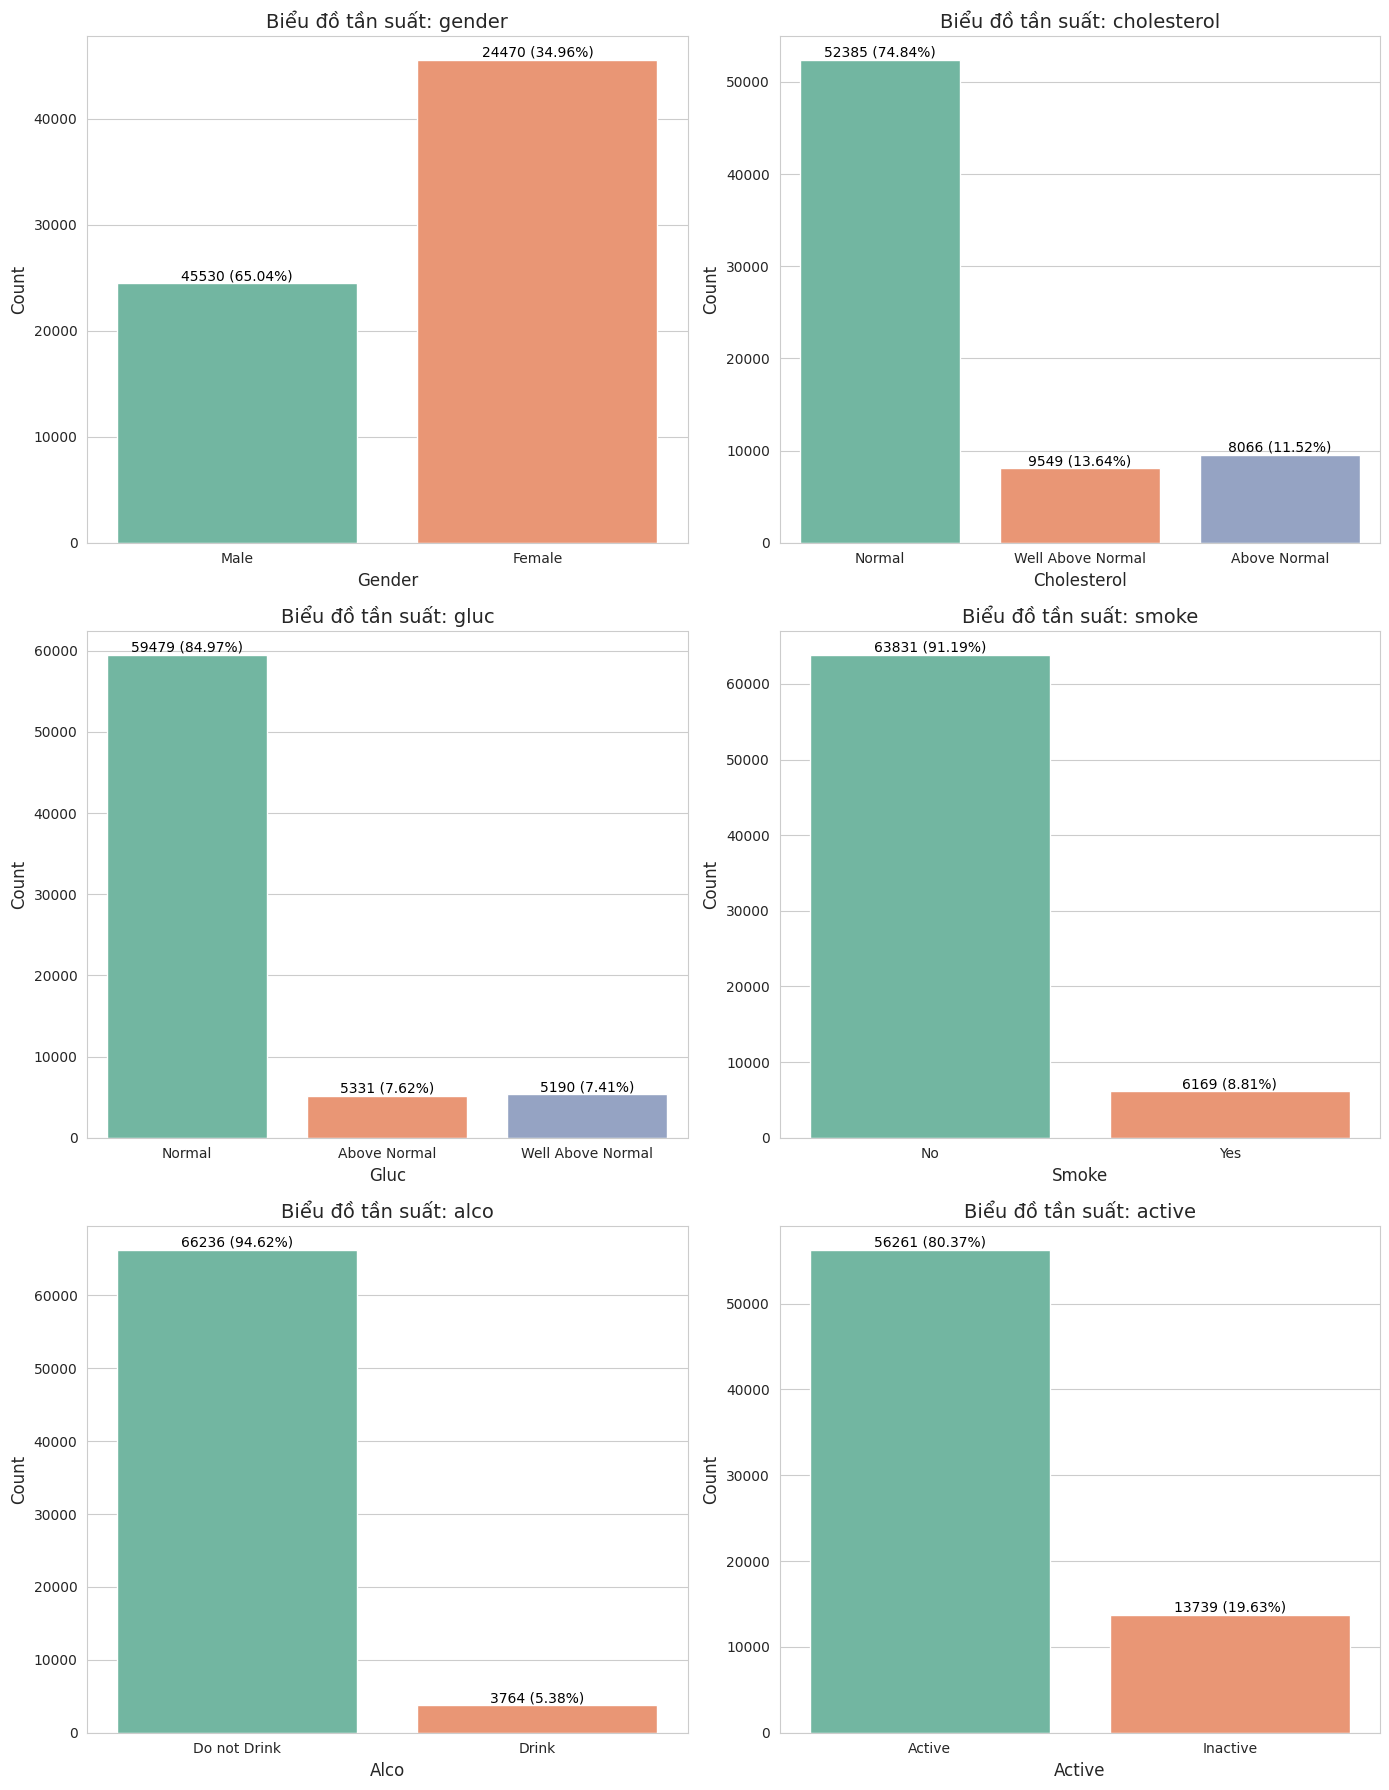

In [13]:
sns.set_style("whitegrid")

n_cols = 2
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))
axes = axes.flatten()

mappings = {
    'cholesterol': {1: "Normal", 2: "Above Normal", 3: "Well Above Normal"},
    'gluc': {1: "Normal", 2: "Above Normal", 3: "Well Above Normal"},
    'gender': {1: "Female", 2: "Male"},
    'smoke': {0: "No", 1: "Yes"},
    'alco': {0: "Do not Drink", 1: "Drink"},
    'active': {1: "Active", 0: "Inactive"},
    'cardio': {1: "Have Disease", 0: "No Disease"}
}
tmp_df = df.copy()
for col, mapping in mappings.items():
    if col in tmp_df.columns:
        tmp_df[col] = tmp_df[col].map(mapping)
for idx, col in enumerate(categorical_cols): 
    ax = axes[idx]
    summary = print_categorical_summary(tmp_df, col)

    sns.countplot(x=col, data=tmp_df, palette='Set2', ax=ax)
    ax.set_title(f"Biểu đồ tần suất: {col}", fontsize=14)
    ax.set_xlabel(col.capitalize(), fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

    # Thêm nhãn đếm và phần trăm
    for i, p in enumerate(ax.patches):
        count = summary.iloc[i]['Số lượng']
        percent = summary.iloc[i]['Tỷ lệ (%)']
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.text(x, y + 2,
                f'{int(count)} ({percent:.2f}%)',
                ha='center', va='bottom',
                fontsize=10, color='black')

plt.tight_layout()
plt.show()

##### Nhận xét
1. gender
* Số lượng nữ cao hơn đáng kể cho với nam:
    * Nữ: 45530 người (~ 65%)
    * Nam: 24470 người (~35%)
* Dữ liệu có sự mất cân bằng giới tính, nữ chiếm ưu thế.
  
2. cholesterol
* Gồm 3 mức:
    * normol: 52385 người (~75%)
    * above normal: 9549 người
    * well above normal: 8066 người
* Phần lớn người trong tập dữ liệu có cholesterol bình thường.
* Tuy nhiên có khoảng 25% người có cholesterol cao → Đây là nhóm cần lưu ý trong phân tích nguy cơ bệnh tim mạch.

3. gluc
* Gồm 3 mức:
    * normal: 59,479 người (~ 85%)
    * above normal: 5,190 người
    * well above normal: ~5331 người
* Rất nhiều người có mức glucose bình thường.
* Số người có đường huyết cao rất nhỏ, chiếm khoảng 15%, chia đều cho 2 mức cao và rất cao → Đây là nhóm cần theo dõi trong phân tích bệnh lý.

4. smoke
* Không hút: 63,831 người (~ 91%)
* Có hút: 6,169 người (~ 9%)
* Phần lớn không hút thuốc.
* Do sự chênh lệch lớn, cần chú ý khi sử dụng trong mô hình học máy vì nhóm hút thuốc có thể không đủ đại diện.

5. alco
* Không uống: 66,236 người (≈ 95%)
* Có uống: 3,764 người (≈ 5%)
* Dữ liệu rất mất cân bằng, nhóm uống rượu chiếm tỉ lệ nhỏ.
  
6. active
* Có hoạt động: 56,261 người (80%)
* Không hoạt động : 13,739 người (20%)
* Đa số có vận động thể chất, phù hợp với hướng sống lành mạnh.
* Tuy nhiên, nhóm thiếu vận động vẫn khá đáng kể → cần xem xét trong phân tích nguy cơ bị bệnh tim.

### 3.2. Phân phối của các cột numerical

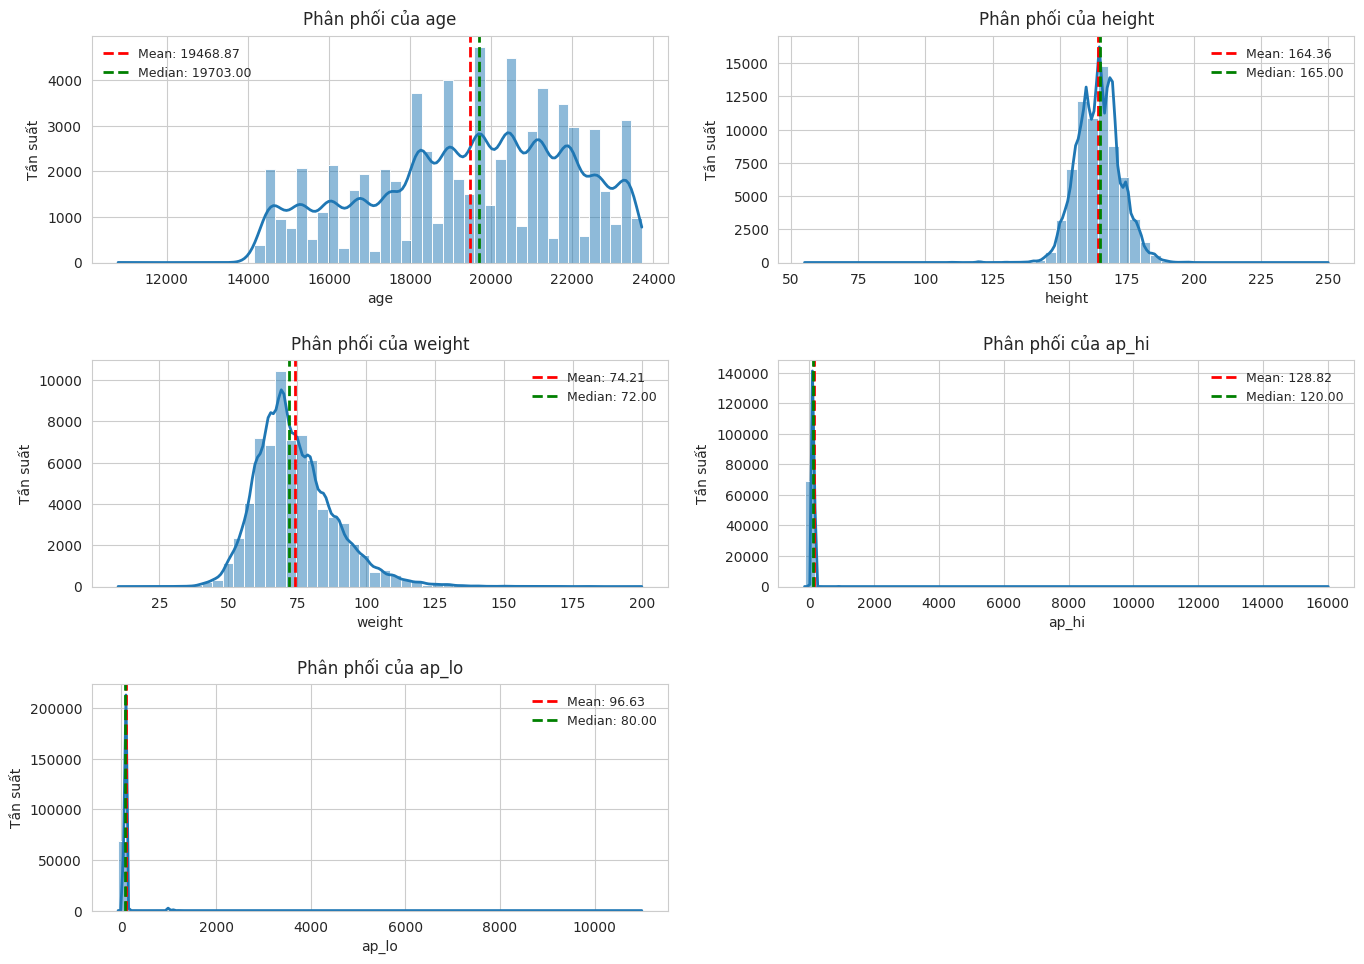

In [14]:
stats = df[numerical_cols].describe()
stats.loc['variance'] = df[numerical_cols].var()

plt.figure(figsize=(14, 10)) 

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i+1)  
    sns.histplot(df[col], kde=True, bins=50, line_kws={'linewidth': 2})
    plt.title(f'Phân phối của {col}', fontsize=12, pad=8)
    plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df[col].mean():.2f}')
    plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=2, label=f'Median: {df[col].median():.2f}')
    plt.legend(fontsize=9, loc='best', frameon=False)
    plt.xlabel(col)
    plt.ylabel('Tần suất')

plt.tight_layout(pad=2.0)
plt.show()

##### Nhận xét
1. age:
* Phân phối lệch trái nhẹ: Mean < Median --> phân phối hơi nghiêng về giá trị nhỏ hơn.
* Có  nhiều giá trị tập trung từ khoảng 15000 - 22000 ngày tuổi.
* Dữ liệu phân tán rộng hơn ở những người trẻ (giá trị thấp)
* Không có outlier rõ ràng

2. height:
* Mean ≈ 164.36, Median ≈ 165: gần bằng nhau => phân phối xấp xỉ chuẩn.(Gaussian)
* Có một vài điểm outlier ở cả hai phía.
* Phần lớn chiều cao nằm trong khoảng 150–180 cm.

3. weight:
* Mean ≈ 74.21, Median ≈ 72: Phân phối lệch phải.
* Đa số giá trị nằm trong khoảng 50–100 kg.
* Có đỉnh rõ rệt ở khoảng 70-80 kg, là cân nặng trung bình phổ biến
* Phần đuôi kéo dài về phía các giá trị cao hơn --> tồn tại một số người có cân nặng rất lớn (outliers)
* Một số outlier như: <30kg hoặc >200kg

4. ap_hi:
* Mean ≈ 128.82, Median = 120: Lệch phải mạnh
* Giá trị bình thường (khoảng 90–140) xuất hiện nhiều, nhưng tồn tại số lượng rất lớn các giá trị bất thường cực cao (nhiều giá trị >2000 và lên đến hàng chục nghìn mmHg) → outliers nghiêm trọng, có thể do lỗi nhập liệu
→ Cần làm sạch dữ liệu, loại bỏ giá trị không thực tế: <80 hoặc >250

5. ap_lo:
* Mean ≈ 96.63, Median = 80: Lệch phải mạnh như ap_hi
* Giống như ap_hi, có rất nhiều ngoại lệ cao bất thường (đến hàng nghìn)
* Đuôi dài do các outlier cực lớn (đến 11000)
* Đỉnh cao ở khoảng 80 mmHg là giá trị bình thường
* Dải giá trị bình thường nên từ 60-90 mmHg

→ Cần xử lý loại bỏ outlier

### 3.3. Phân phối của nhãn

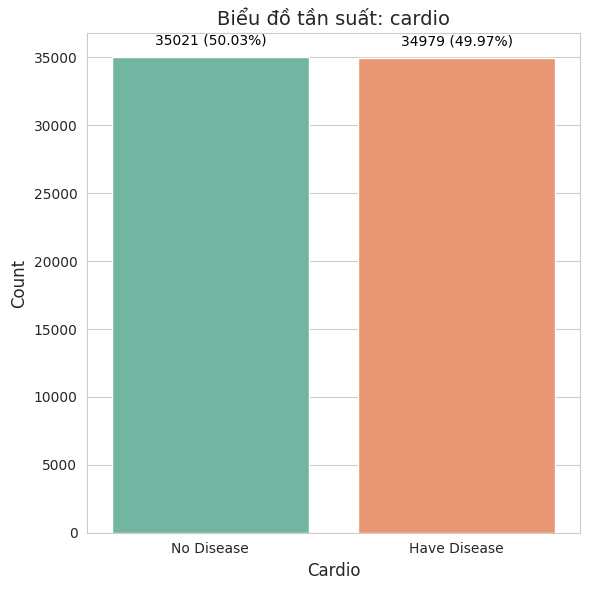

In [15]:
sns.set_style("whitegrid")  

summary = print_categorical_summary(tmp_df, 'cardio')

plt.figure(figsize=(6, 6))  
ax = sns.countplot(x='cardio', data=tmp_df, palette='Set2')  

plt.title(f"Biểu đồ tần suất: {'cardio'}", fontsize=14)
plt.xlabel('cardio'.capitalize(), fontsize=12)
plt.ylabel('Count', fontsize=12)

for i, p in enumerate(ax.patches):
    count = summary.iloc[i]['Số lượng']
    percent = summary.iloc[i]['Tỷ lệ (%)']
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    ax.text(x, y + y * 0.02,  
            f'{int(count)} ({percent:.2f}%)',
            ha='center', va='bottom',
            fontsize=10, color='black')

plt.tight_layout()
plt.show()

### 3.4. Biểu diễn outlier

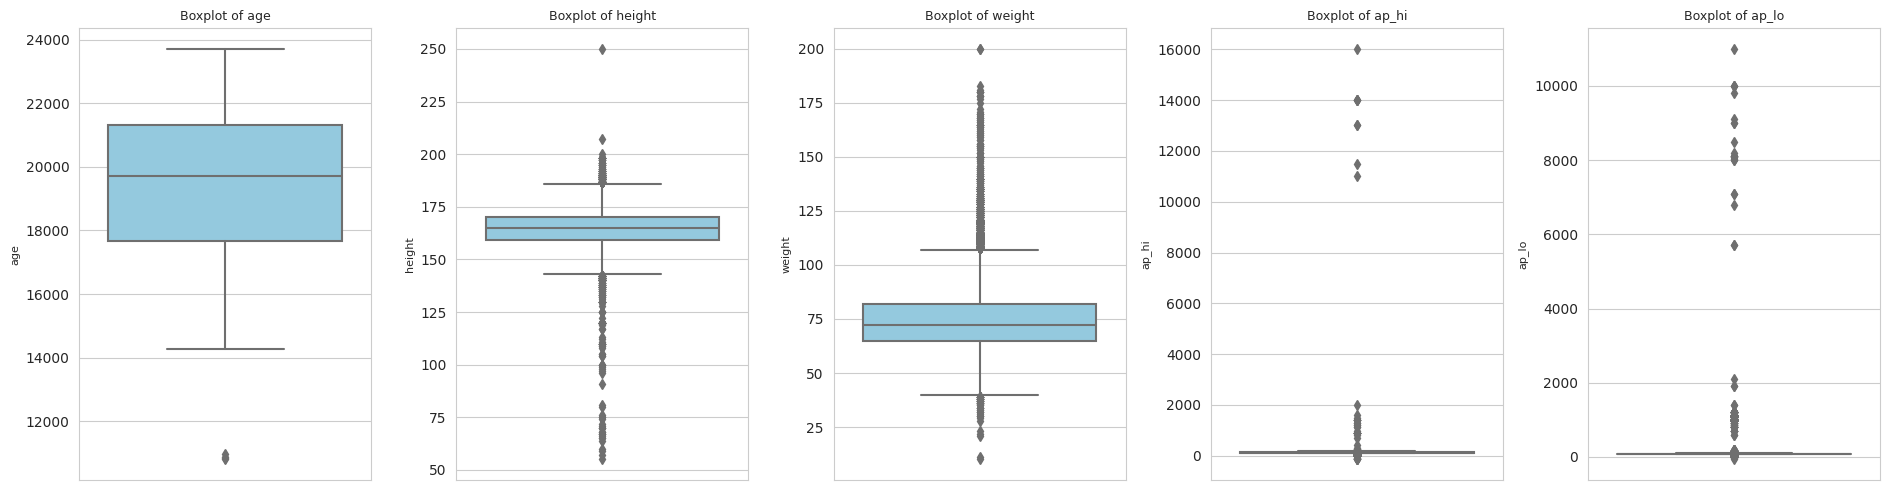

In [16]:
n_cols = 5
n_rows = math.ceil(len(numerical_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 5))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, y=col, color="skyblue", ax=axes[i]) 
    axes[i].set_title(f'Boxplot of {col}', fontsize=9)
    axes[i].set_ylabel(col, fontsize=8)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

##### Nhận xét
1. age: có một vài outlier thấp (~11000) nhưng nhìn chung khá ổn
2. height: có outlier rõ ràng cả 2 phía. Khoảng IQR hẹp, cho thấy phần lớn dữ liệu tập trung ở đó.
3. weight: cũng có outlier 2 phía. Khoảng IQR hẹp, cho thấy phần lớn dữ liệu tập trung ở đó.
4. ap_hi: rất nhiều outlier, một số vượt 1000 thâm chí đến 16000. Khoảng IQR rất hẹp, cần kiểm tra thêm các outliers này.
5. ap_lo: tương tự ap_hi, nhiều giá trị vượt 5000 hoặc âm đều là outlier. Khoảng IQR rất hẹp, cần kiểm tra thêm các outliers này.

In [17]:
def count_outliers_iqr(df, columns):
    outlier_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        outlier_dict[col] = outlier_count
    return outlier_dict
outlier_counts = count_outliers_iqr(df, numerical_cols)
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Thuộc tính', 'Số lượng outliers'])
display(outlier_df)

,Thuộc tính,Số lượng outliers
0,age,4
1,height,519
2,weight,1819
3,ap_hi,1435
4,ap_lo,4632


##### Nhận xét
* age: Gần như không có giá trị ngoại lệ
* height: Có 519 giá trị ngoại lệ, bao gồm cả chiều cao quá thấp (ví dụ <100cm) hoặc quá cao (>220cm), nhiều khả năng do lỗi nhập liệu.
* weight: Có tới 1,819 giá trị bất thường. Những trường hợp cân nặng dưới 30kg hoặc trên 200kg không phản ánh hợp lý đặc điểm dân số trưởng thành và cần được xử lý.
* ap_hi (huyết áp tâm thu) và ap_lo (huyết áp tâm trương): Có số lượng ngoại lệ rất lớn (lần lượt là 1,435 và 4,632 giá trị), bao gồm cả các giá trị âm, bằng 0, hoặc vượt ngưỡng sinh lý cho phép. 

### 3.5. Phân tích mối quan hệ giữa các thuộc tính

#### 3.5.1. Heatmap

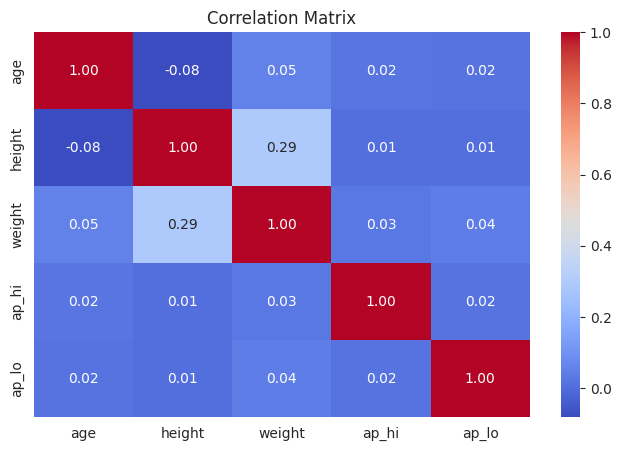

In [18]:
plt.figure(figsize=(8, 5))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### Nhận xét:
1. Có sự tương quan vừa phải giữa height và weight, điều phản ánh đúng thực tế khi người cao hơn thường có xu hướng nặng cân hơn và ngược lại.
2. Tương quan ap_hi và ap_lo rất thấp (0.02), trong khi thực tế ap_hi và ap_lo có tương quan thuận trong thực tế. Khả năng cao do các outliers đã ảnh hưởng đến tương quan này.

##### Vẽ biểu đồ để xem mối quan hệ giữa height-weight, ap_hi-ap_lo

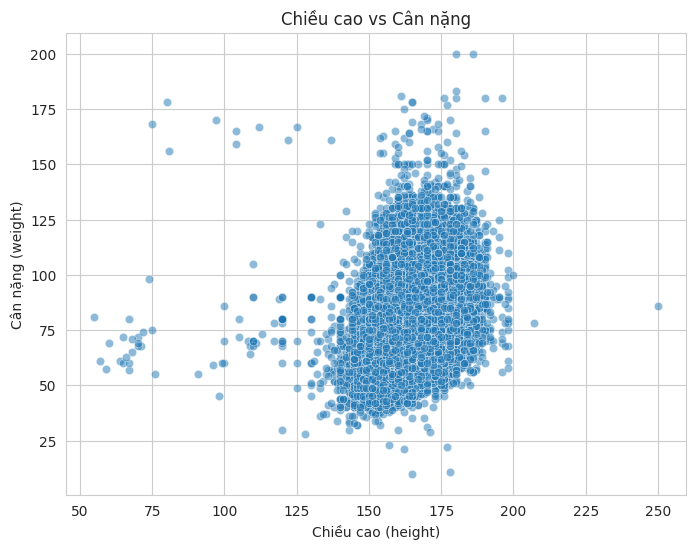

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='height', y='weight', data=df, alpha=0.5)
plt.title('Chiều cao vs Cân nặng')
plt.xlabel('Chiều cao (height)')
plt.ylabel('Cân nặng (weight)')
plt.grid(True)
plt.show()

##### Nhận xét: 
- Phân bố dữ liệu dạng elip
- Có tương quan nhẹ giữa height và weight
- Một số điểm nằm xa khỏi cụm chính
- Phần lớn chiều cao nằm trong khoảng 150–190 cm, và cân nặng từ 40–120 kg.

=> Mối quan hệ hợp lý

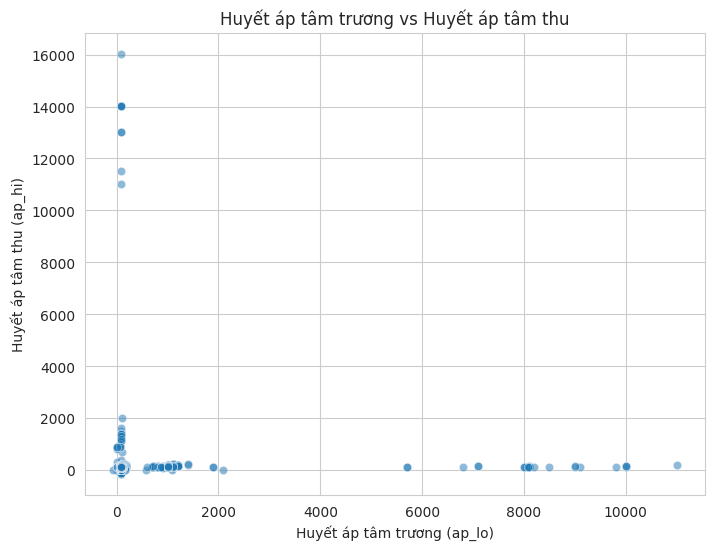

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ap_lo', y='ap_hi', data=df, alpha=0.5)
plt.title('Huyết áp tâm trương vs Huyết áp tâm thu')
plt.xlabel('Huyết áp tâm trương (ap_lo)')
plt.ylabel('Huyết áp tâm thu (ap_hi)')
plt.grid(True)
plt.show()

##### Nhận xét:
- Biểu đồ bị bóp méo nghiêm trọng do quá nhiều outlier
- Các điểm chính dồn vào khu vực rất nhỏ gần gốc tọa độ
- Do có nhiều outliers của ap_hi và ap_lo nên mối tương quan giữa chúng thấp, đề xuất loại bỏ outliers để quan sát tương quan.

#### 3.5.2. Scatter matrix

In [21]:
def plotScatterMatrix(df, numerical_cols, plotSize=15, textSize=10):
    df = df[numerical_cols]
    df = df[[col for col in df.columns if df[col].nunique() > 1]]

    if len(df.columns) > 10:
        df = df.iloc[:, :10]

    ax_array = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')

    # Tính ma trận tương quan
    corrs = df.corr().values
    n = len(df.columns)

    for i in range(n):
        for j in range(n):
            if i < j:
                ax = ax_array[i, j]
                ax.annotate(f"Corr = {corrs[i, j]:.2f}",
                            xy=(0.5, 0.9), xycoords='axes fraction',
                            ha='center', va='center', fontsize=textSize,
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5))

    plt.suptitle('Scatter Matrix & Correlation Coefficients', size=textSize + 2)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95) 
    plt.show()

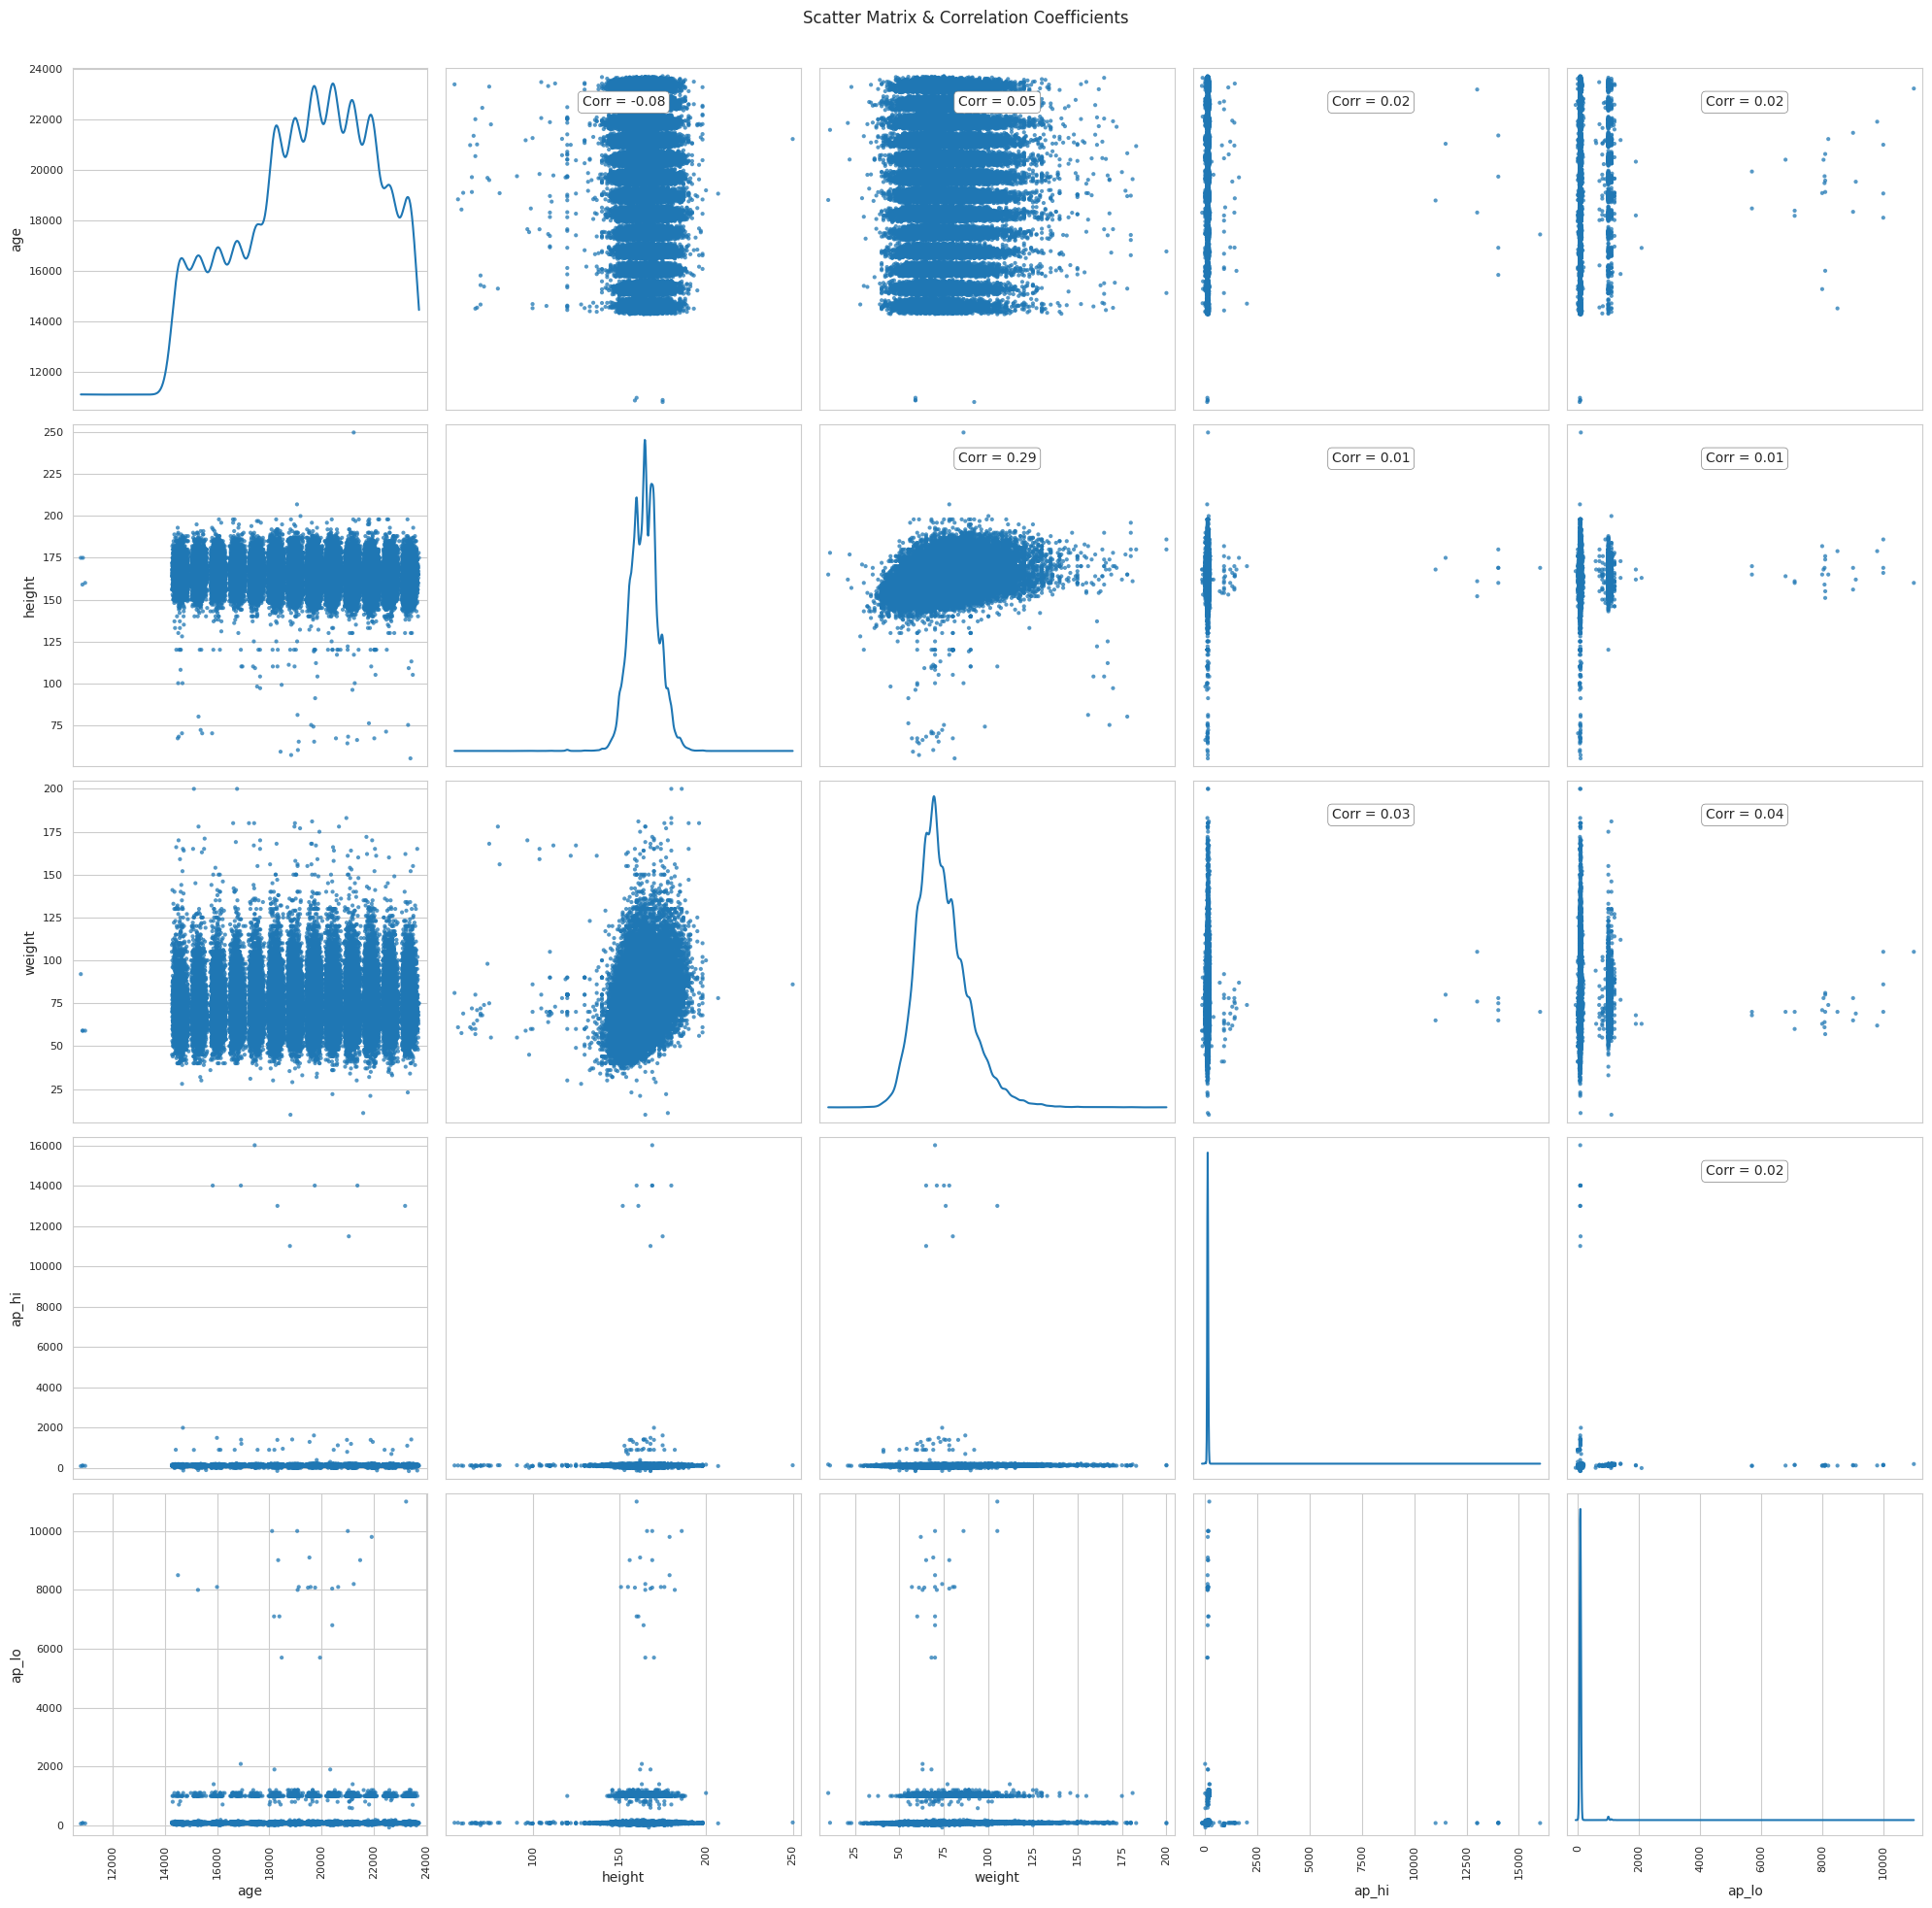

In [22]:
plotScatterMatrix(df,numerical_cols, 20, 10)

##### Nhận xét:
- Cặp biến height và weight có tương quan dương rõ ràng (hệ số tương quan ≈ 0.29)
- Các cặp còn lại hầu như không có tương quan hoặc tương quan yếu

#### 3.5.3. Mối quan hệ giữa biến numerical và biến categorical

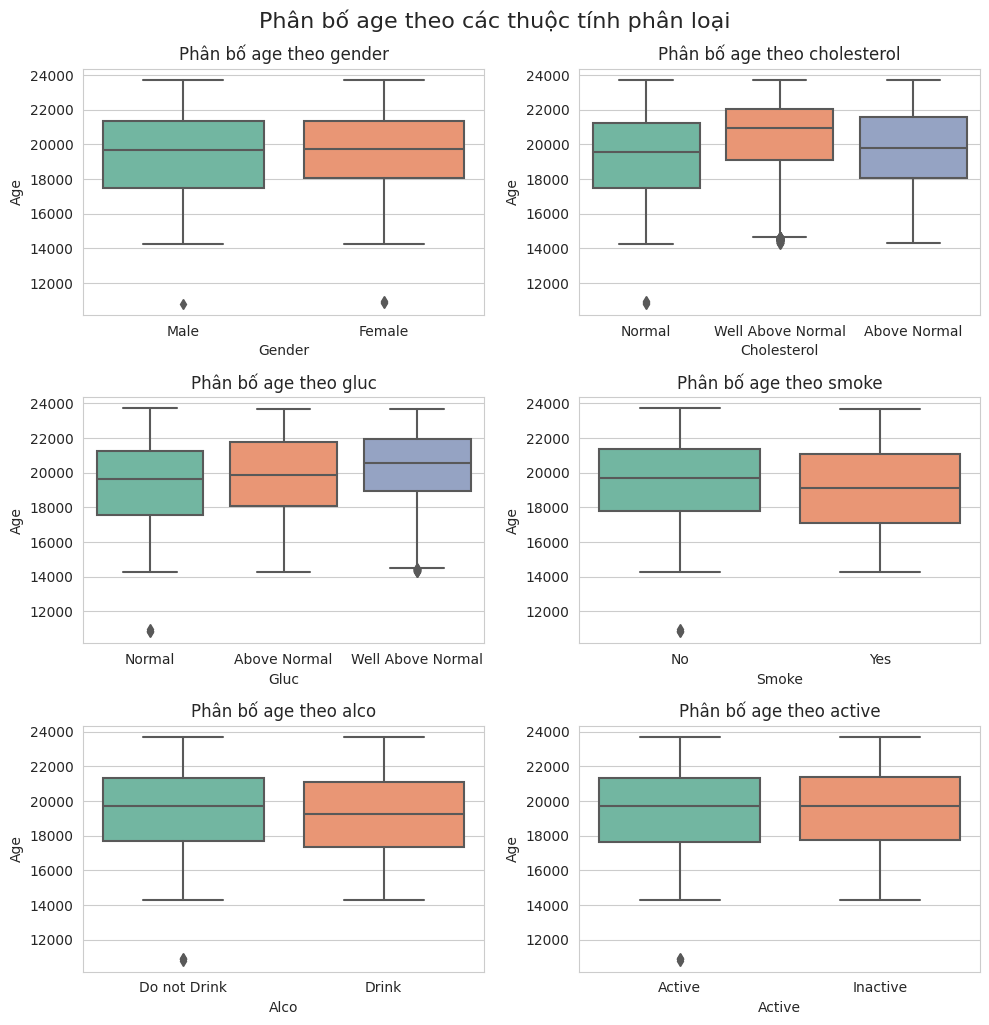

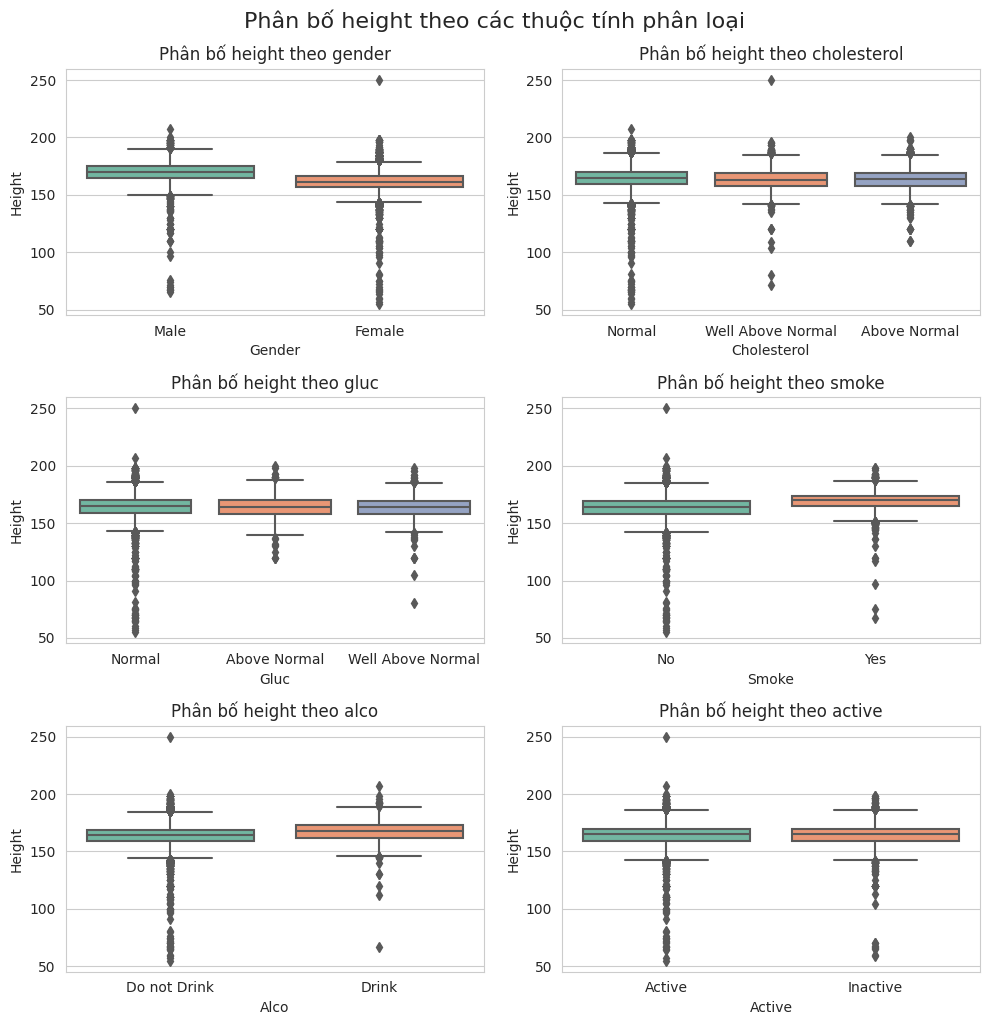

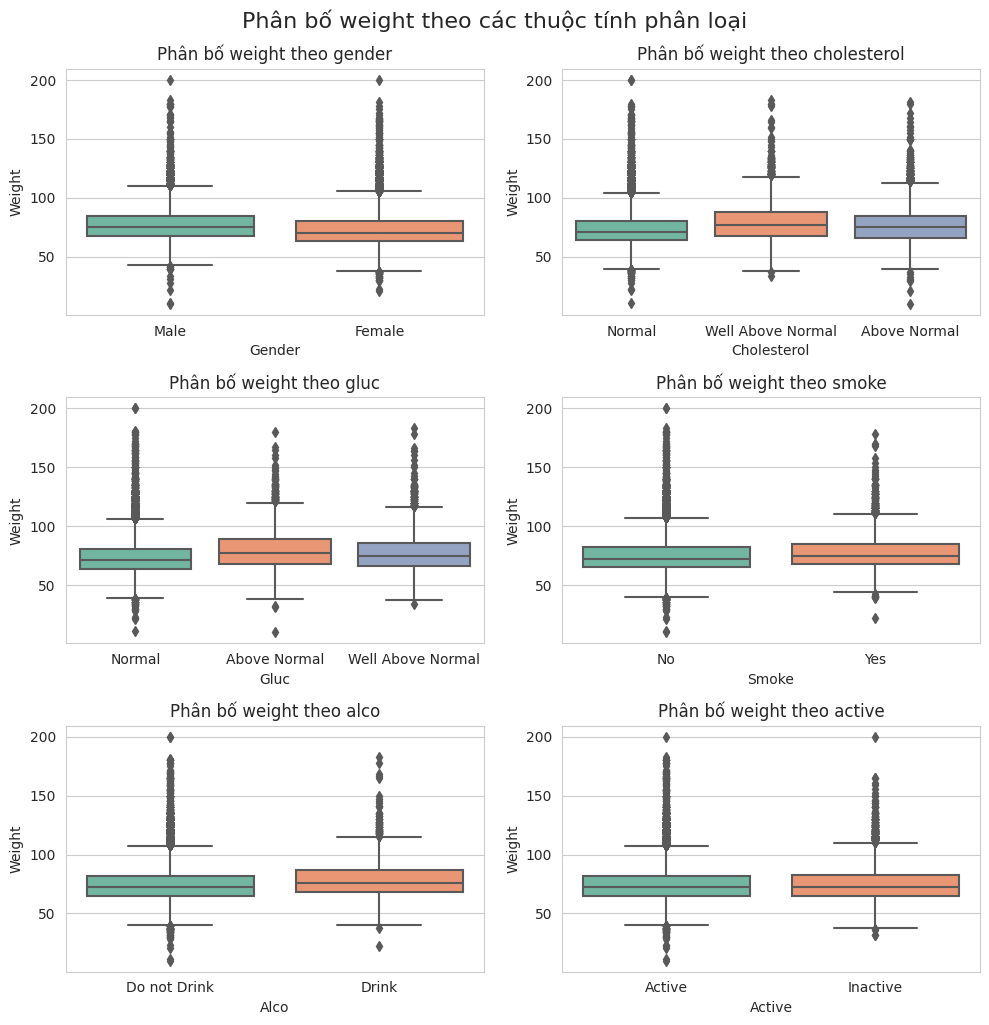

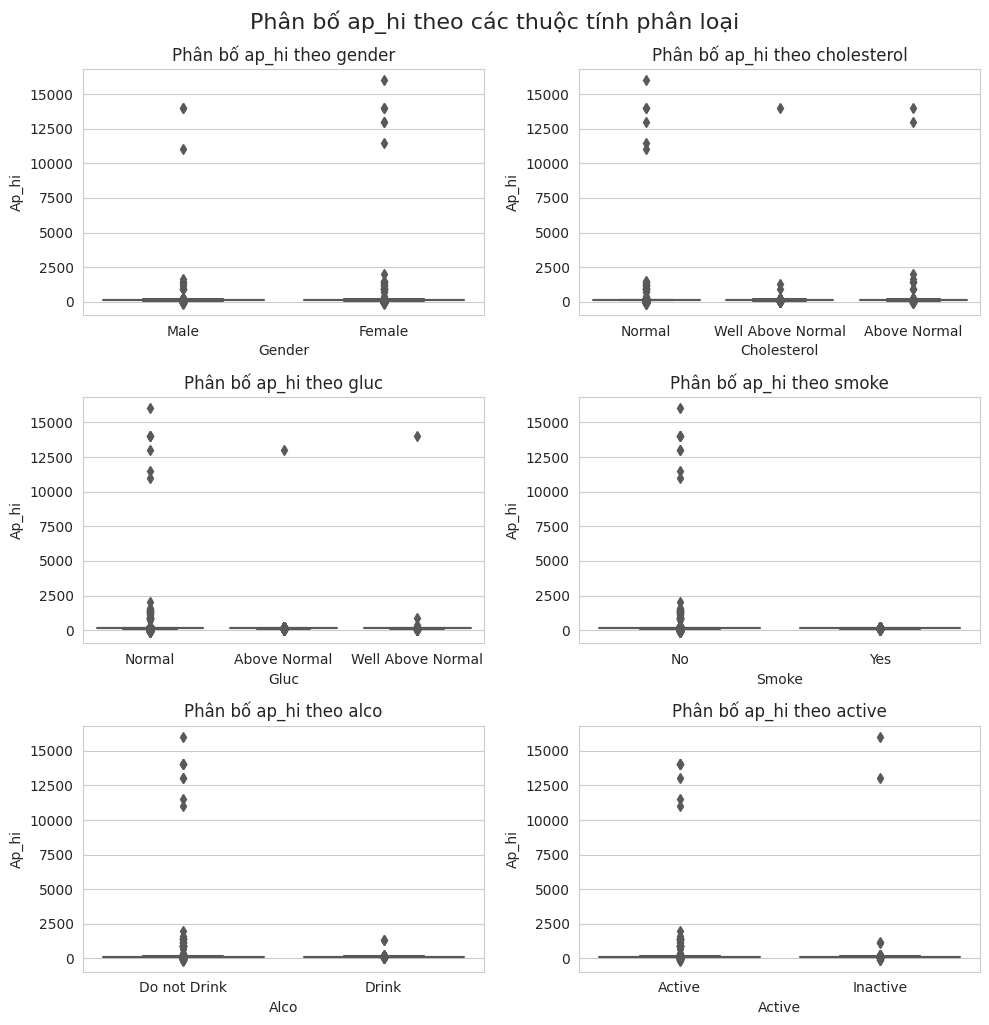

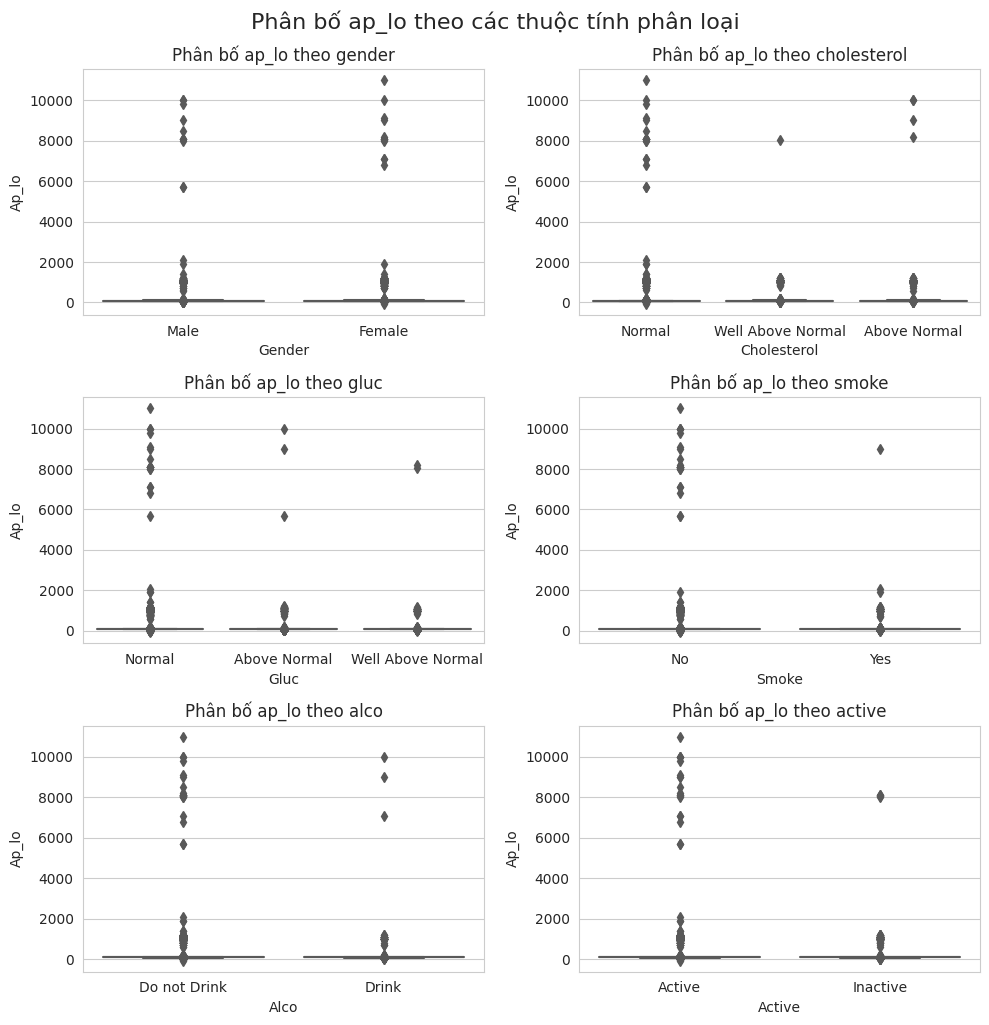

In [23]:
def plot_numerical_by_categorical_boxplot(df, numerical_col, categorical_cols, palette='Set2'):
    sns.set_style("whitegrid")
    n_cols = 2
    n_rows = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axes = axes.flatten()

    for idx, cat_col in enumerate(categorical_cols):
        ax = axes[idx]
        sns.boxplot(data=df, x=cat_col, y=numerical_col, palette=palette, ax=ax)
        ax.set_title(f'Phân bố {numerical_col} theo {cat_col}')
        ax.set_xlabel(cat_col.capitalize())
        ax.set_ylabel(numerical_col.capitalize())
        ax.tick_params(axis='x') 

    for j in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f'Phân bố {numerical_col} theo các thuộc tính phân loại', fontsize=16, y=1.02)
    plt.show()

for col in numerical_cols: 
    plot_numerical_by_categorical_boxplot(tmp_df, numerical_col=col, categorical_cols=categorical_cols)

##### Nhận xét
1. Phân bố age theo gender: Độ tuổi phổ biến của cả 2 giới khá giống nhau, đều rơi vào khoảng 18.000~20.000. Có xuất hiện một vài outliers về age ở cả 2 giới tính.
2.	Phân bố age theo cholesterol: Những người có cholesterol cao có xu hướng cao tuổi hơn.
3.	Phân bố age theo gluc: Những người có gluc cao có xu hướng tăng theo độ tuổi.
4.	Phân bố age theo smoke, alco, active: Không có sự khác biệt đáng kể giữa 2 phân phối của từng biểu đồ.
5.	Phân bố height theo gender: Nam giới có xu hướng chiều cao cao hơn nữ giới. IQR hẹp ở cả 2 giới tính, nên dữ liệu tập trung nhiều ở khoảng 165-175. Tuy nhiên lại xuất hiện nhiều outliers bất thường, cần phải kiểm tra lại.
6.	Phân bố height theo cholesterol: IQR hẹp. Cũng xuất hiện nhiều outliers về height (tương tự như phân bối height theo gender).
7.	Phân bố height theo gluc: Tương tự như biểu đồ trên khi IQR hẹp và có nhiều outliers.
8.	Phân bố height theo smoke: IQR hẹp, xuất hiện nhiều outliers. Những người hút thuốc có xu hướng cao hơn.
9.	Phân bố height theo alco: IQR hẹp, nhiều outliers. Những người uống rượu có xu hướng cao hơn.
10.	Phân bố height theo active: IQR hẹp, nhiều outliers. Khoảng IQR của 2 phân bố khá giống nhau.
11.	Phân bố weight theo gender: IQR hẹp, nhiều outliers. Nam giới có xu hướng nặng cân hơn nữ giới.
12.	Phân bố weight theo cholesterol: IQR hẹp, nhiều outliers. Những người nặng cân hơn có xu hướng có cholesterol cao hơn.
13.	Phân bố weight theo gluc: IQR hẹp, nhiều outliers. Những người nặng cân có xu hướng gluc cao hơn.
14.	Phân bố weight theo smoke: IQR hẹp, nhiều outliers. Những người nặng cân có xu hướng hút thuốc hơn (một chút).
15.	Phân bố weight theo alco: IQR hẹp, nhiều outliers. Những người nặng cân hơn có xu hướng uống rượu nhiều hơn.
16.	Phân bố weight theo active: IQR hẹp, nhiều outliers. IQR của 2 phân bố khá giống nhau.
17.	Phân bố ap_hi và ap_lo theo các thuộc tính phân loại: Do có nhiều outliers nên việc quan sát phân bố khá khó khăn. IQR rất hẹp.



#### 3.5.4. Tương quan với nhãn 

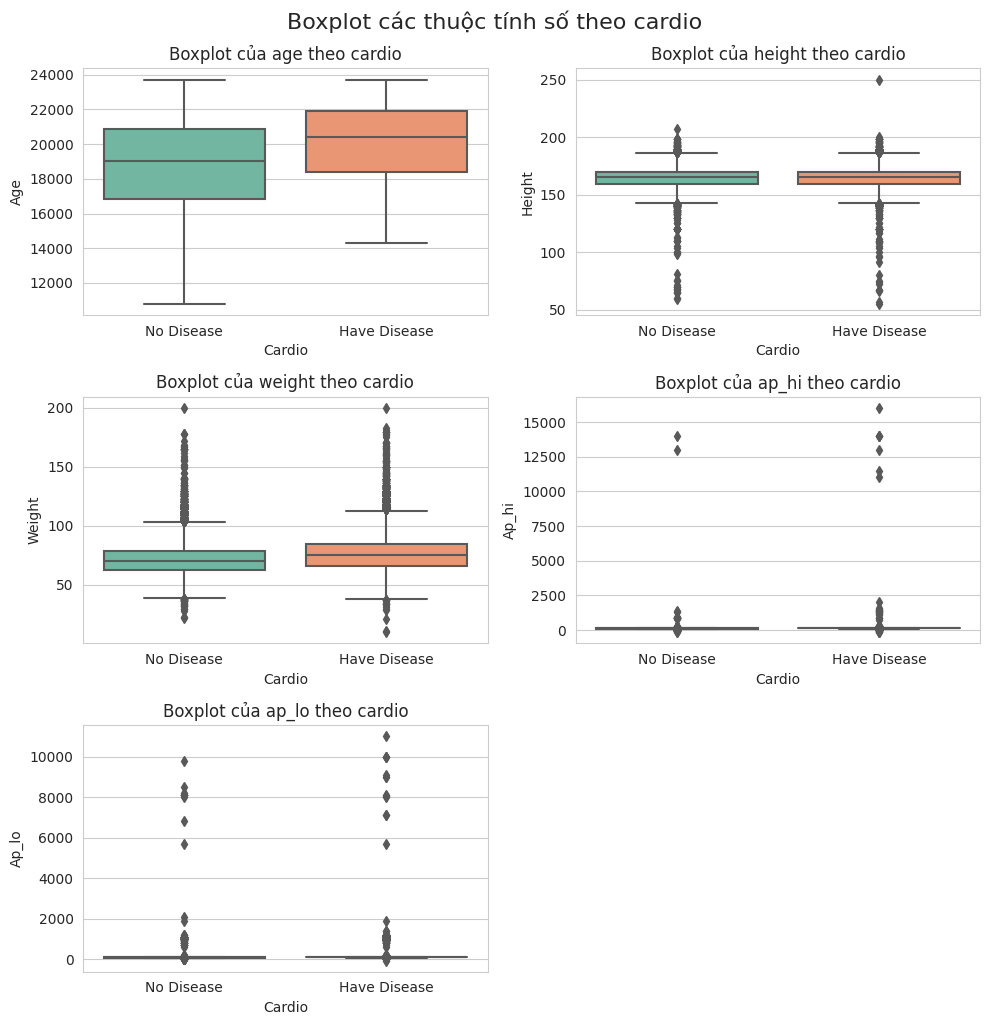

In [24]:
sns.set_style("whitegrid")

n_cols = 2
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()

for idx, num_col in enumerate(numerical_cols):
    ax = axes[idx]
    sns.boxplot(data=tmp_df, x='cardio', y=num_col, palette='Set2', ax=ax)
    ax.set_title(f'Boxplot của {num_col} theo cardio')
    ax.set_xlabel('Cardio')
    ax.set_ylabel(num_col.capitalize())

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Boxplot các thuộc tính số theo cardio', fontsize=16, y=1.02)
plt.show()


##### Nhận xét
1.	Boxplot của age theo cardio: Người bị bệnh tim có xu hướng cao tuổi hơn.
2.	Boxplot của height theo cardio: IQR hẹp, xuất hiện nhiều outliers. Phân bố chiều cao của người bị bệnh và không bị bệnh khá tương đồng.
3.	Boxplot của weight theo cardio: IQR hẹp, nhiều outliers. Những người bị bệnh tim có xu hướng nặng cân hơn.
4.	Boxplot của ap_hi theo cardio: IQR rất hẹp, xuất hiện rất nhiều outliers. Cần loại bỏ outliers để quan sát phân bố rõ hơn. 
5.	Boxplot của ap_lo theo cardio: IQR rất hẹp, xuất hiện rất nhiều outliers. Cần loại bỏ outliers để quan sát phân bố rõ hơn.


In [25]:
def plot_categorical_counts(df, categorical_cols, target_col='cardio', palette='Set2'):
    sns.set_style("whitegrid")

    n_cols = 2
    n_rows = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 16))
    axes = axes.flatten()

    for idx, col in enumerate(categorical_cols):
        ax = axes[idx]
        sns.countplot(x=col, hue=target_col, data=df, palette=palette, ax=ax)

        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(f'{height:.0f}',
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            fontsize=10, color='black',
                            xytext=(0, 3), textcoords='offset points')

        ax.set_title(f'{col.capitalize()} Count by {target_col.capitalize()}')
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel('Count')
        ax.legend(title=target_col.capitalize())

    plt.tight_layout()
    plt.suptitle('Biểu đồ đếm theo thuộc tính phân loại và nhãn cardio', fontsize=16, y=1.02)
    plt.show()

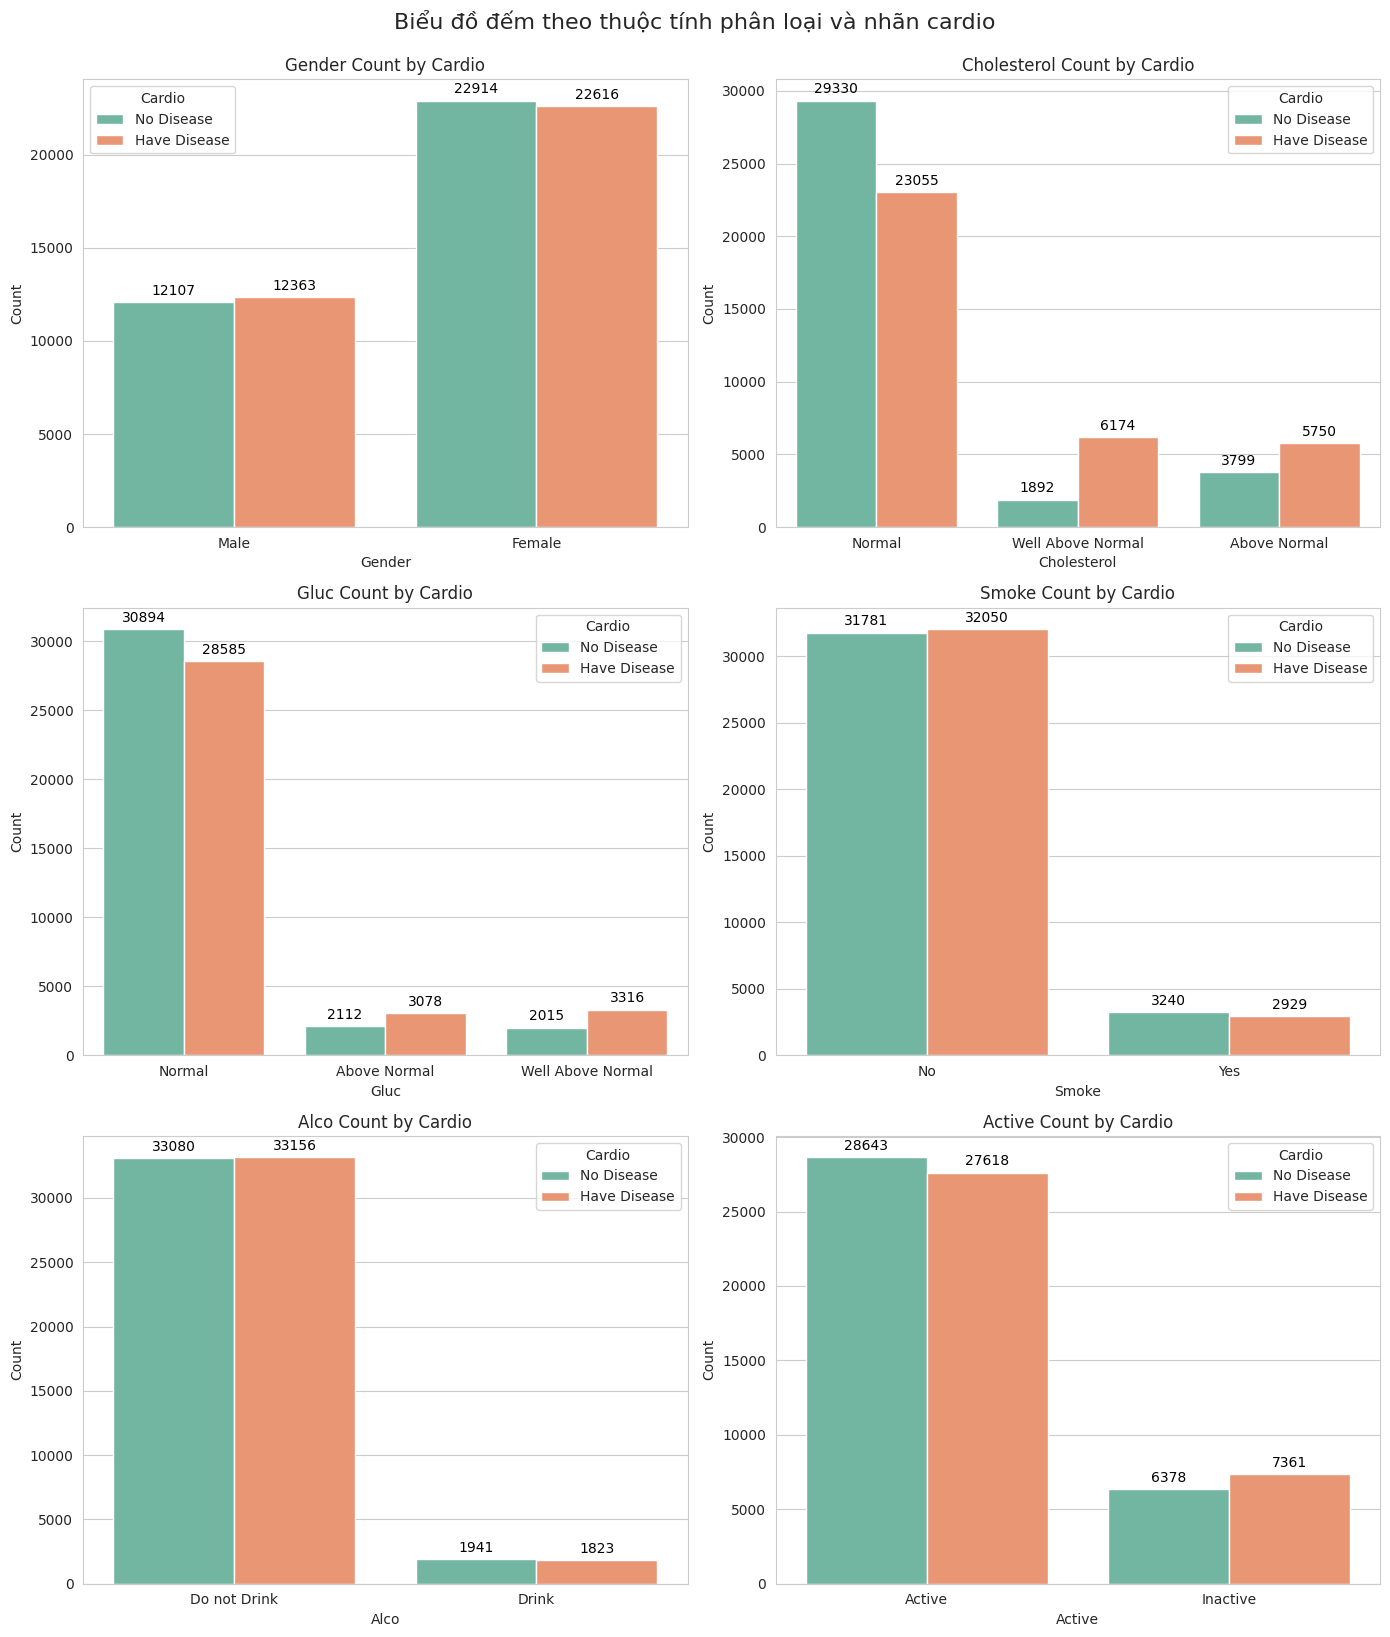

In [26]:
plot_categorical_counts(tmp_df, categorical_cols)

##### Nhận xét
1. Gender Count by Cardio: Tỉ lệ mắc bệnh của nam giới và nữ giới tương đương nhau.
2. Cholesterol Count by Cardio: Những người có mức cholesterol bình thường ít có xu hướng mắc bệnh tim hơn, trong khi ở những người có mức cholesterol cao hơn lại có xu hướng bị bệnh tim cao hơn đáng kể, cho thấy mức cholesterol có mối liên hệ  với nguy cơ mắc bệnh tim.
3. Gluc Count by Cardio: Tương tự như biểu đồ 2, khi những người có gluc cao thường có xu hướng mắc bệnh tim hơn, cho thấy gluc có mối liên hệ với nguy cơ mắc bệnh tim
4. Smoke Count by Cardio: Tỉ lệ mắc bệnh tim của người không hút thuốc và có hút thuốc tương đương nhau, cho thấy hút thuốc không có mối liên hệ rõ ràng với mắc bệnh tim.
5. Alco Count by Cardio: Tương tự như biểu đồ 4, không có mối liên hệ rõ ràng giữa uống rượu với mắc bệnh tim.
6. Active Count by Cardio: Những người vận động nhiều có xu hướng ít mắc bệnh tim hơn, trong khi ở những người vận động ít, tỉ lệ mắc bệnh tim cao hơn, cho thấy xu hướng nhẹ giữa việc ít vận động và nguy cơ mắc bệnh tim.

# II. Data Preprocessing

In [14]:
target = 'cardio'
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
numerical_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']

## 1. Xử lý outlier

### Hướng xử lý 1:  Loại bỏ outliers trong DataFrame, dựa trên phương pháp IQR (Interquartile Range) đối với các cột được chỉ định.

In [28]:
def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

df_cleaned = remove_outliers_iqr(df, ['age', 'height', 'weight', 'ap_hi', 'ap_lo'])
df_cleaned

### Hướng xử lý 2:  Giới hạn (clip) các giá trị cực đoan trong các cột định sẵn theo ngưỡng thủ công, loại bỏ các hàng sai logic trong huyết áp.

In [10]:
def clip_outliers(df):
    df_clipped = df.copy()
    df_clipped['height'] = df_clipped['height'].clip(lower=100, upper=220)
    df_clipped['weight'] = df_clipped['weight'].clip(lower=30, upper=180)
    df_clipped['ap_hi'] = df_clipped['ap_hi'].clip(lower=60, upper=250)
    df_clipped['ap_lo'] = df_clipped['ap_lo'].clip(lower=40, upper=150)
    
    # Loại bỏ hàng sai logic
    df_clipped = df_clipped[df_clipped['ap_hi'] > df_clipped['ap_lo']]
    return df_clipped

df_cleaned = clip_outliers(df)
df_cleaned

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [12]:
df_cleaned['age'] = (df_cleaned['age'] / 365).astype(int)
df_cleaned['height'] = (df_cleaned['height'] /100).astype(float)
df_cleaned['BMI'] = (df_cleaned.weight /(df_cleaned['height']**2)).astype(float)
df_cleaned

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,51,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,47,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,1.68,76.0,120,80,1,1,1,0,1,0,26.927438
69996,99995,61,1,1.58,126.0,140,90,2,2,0,0,1,1,50.472681
69997,99996,52,2,1.83,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,1.63,72.0,135,80,1,2,0,0,0,1,27.099251


### Chia tập train-test

In [15]:
X = df_cleaned.drop(columns=[target, 'id'])
y = df_cleaned[target]

In [16]:
test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

### Pipeline tiền xử lý dữ liệu

In [19]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cate_tranformer  = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ("cate", cate_tranformer, categorical_cols),
    ("num", num_transformer, numerical_cols)
])

# III. Các thuật toán

In [20]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## 1. Logistic Regression

Accuracy : 0.7271
Precision: 0.7569
Recall   : 0.6650
F1-score : 0.7079

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6957
           1       0.76      0.66      0.71      6886

    accuracy                           0.73     13843
   macro avg       0.73      0.73      0.73     13843
weighted avg       0.73      0.73      0.73     13843



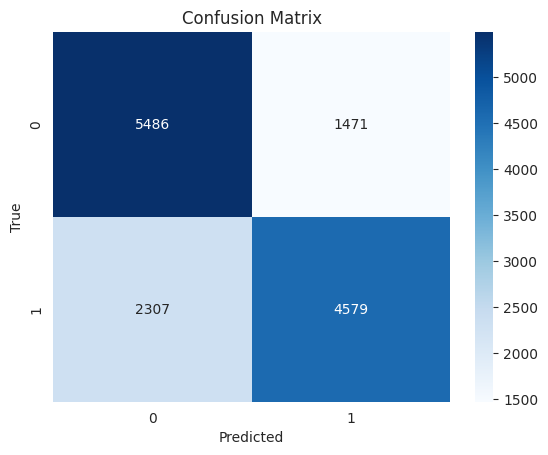

In [35]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])
log_reg.fit(X_train, y_train)
evaluate_model(log_reg, X_test, y_test)

## 2. Naive Bayes

Accuracy : 0.6855
Precision: 0.7417
Recall   : 0.5642
F1-score : 0.6409

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      6957
           1       0.74      0.56      0.64      6886

    accuracy                           0.69     13843
   macro avg       0.70      0.68      0.68     13843
weighted avg       0.70      0.69      0.68     13843



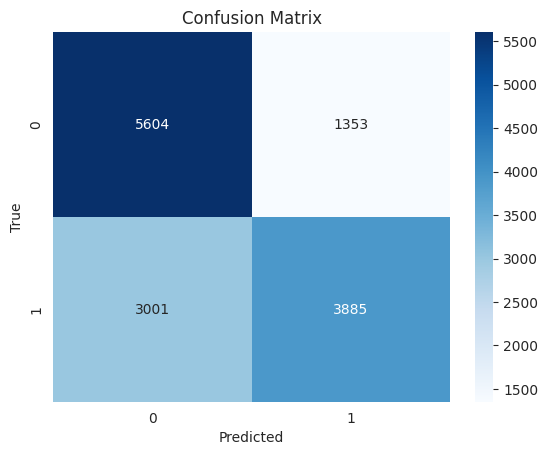

In [36]:
gauss_nb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GaussianNB())
])
gauss_nb.fit(X_train, y_train)
evaluate_model(gauss_nb, X_test, y_test)

## 3. K-Nearest neigbors

Best k = 76, Cross-Validated Accuracy = 0.7311


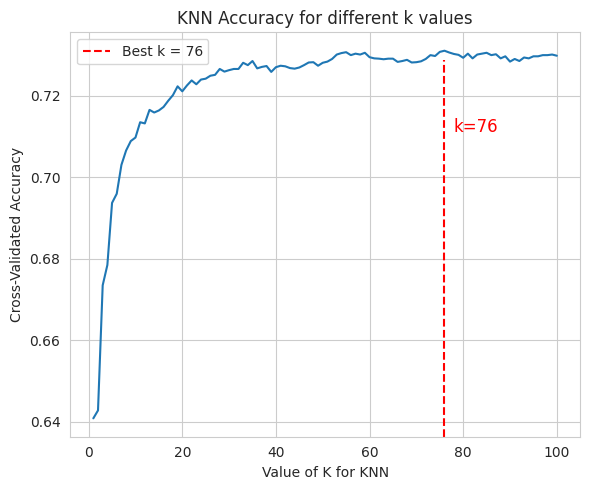

Accuracy : 0.7311
Precision: 0.7688
Recall   : 0.6568
F1-score : 0.7084

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      6957
           1       0.77      0.66      0.71      6886

    accuracy                           0.73     13843
   macro avg       0.74      0.73      0.73     13843
weighted avg       0.74      0.73      0.73     13843



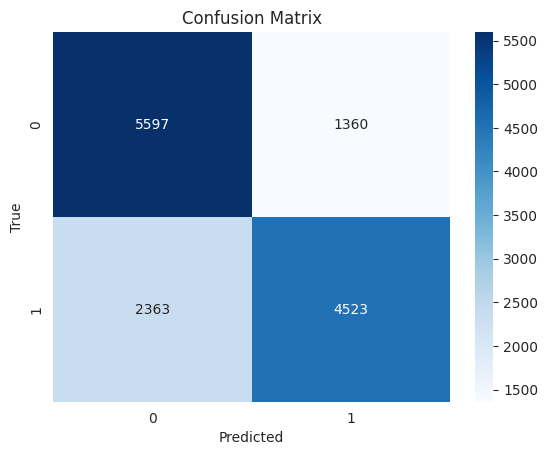

ROC-AUC Score: 0.7905


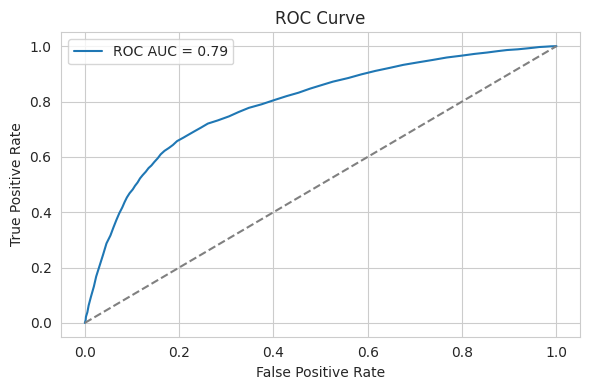

In [37]:
k_range = list(range(1, 101))
scores = []

for k in k_range:
    knn_pipe = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=k))
    ])
    knn_pipe.fit(X_train, y_train)
    score = knn_pipe.score(X_test, y_test)
    scores.append(score)

m = scores.index(max(scores)) + 1
print(f"Best k = {m}, Cross-Validated Accuracy = {scores[m-1]:.4f}")

f, ax = plt.subplots(figsize=(6, 5))
ax.plot(k_range, scores)
ax.axvline(m, ls='--', ymax=max(scores)+0.2, c='r', label=f'Best k = {m}')
ax.text(x=m+2, y=scores[m-1]-0.02, s=f"k={m}", fontsize=12, color='red')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title("KNN Accuracy for different k values")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

best_knn = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=m))
])
best_knn.fit(X_train, y_train)

evaluate_model(best_knn, X_test, y_test)

y_prob = best_knn.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Decision Tree và Random Forest

In [38]:
param_grid_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

In [39]:
models = {
    "Decision Tree": (DecisionTreeClassifier(random_state=42), param_grid_tree),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_rf),
}

Decision Tree
Decision Tree - Best Params: {'max_depth': 5, 'min_samples_split': 2}
Accuracy : 0.7326
Precision: 0.7882
Recall   : 0.6323
F1-score : 0.7017

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      6957
           1       0.79      0.63      0.70      6886

    accuracy                           0.73     13843
   macro avg       0.74      0.73      0.73     13843
weighted avg       0.74      0.73      0.73     13843



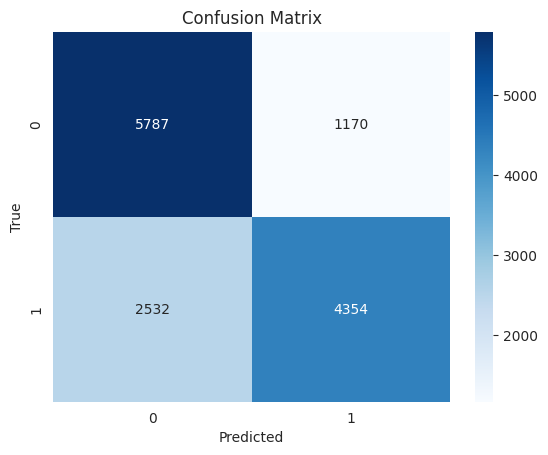

Random Forest
Random Forest - Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy : 0.7354
Precision: 0.7660
Recall   : 0.6740
F1-score : 0.7170

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6957
           1       0.77      0.67      0.72      6886

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.73     13843
weighted avg       0.74      0.74      0.73     13843



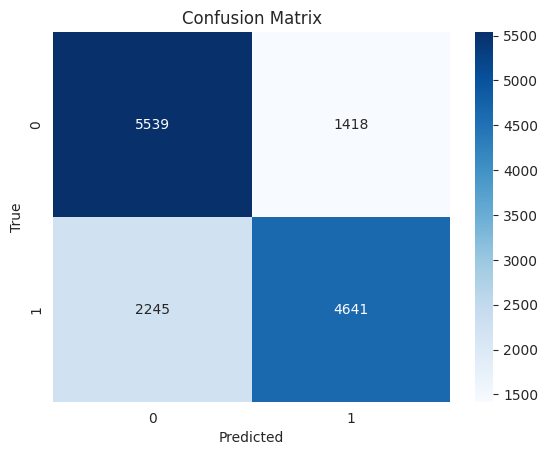

In [40]:
for name, (model, param_grid) in models.items():
    print(f"{name}")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"{name} - Best Params: {grid.best_params_}")
    evaluate_model(best_model, X_test, y_test)

## 5. Boosting: LightGBM và XGBoost

### 5.1 XGBoost

Accuracy : 0.7358
Precision: 0.7607
Recall   : 0.6840
F1-score : 0.7203

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      6957
           1       0.76      0.68      0.72      6886

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.73     13843
weighted avg       0.74      0.74      0.74     13843



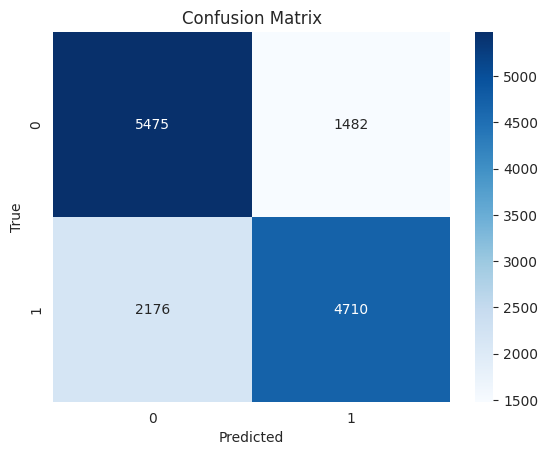

In [41]:
xgboost = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

xgboost.fit(X_train, y_train)

evaluate_model(xgboost, X_test, y_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found:
{'colsample_bytree': 0.7468055921327309, 'learning_rate': 0.041198904067240534, 'max_depth': 5, 'n_estimators': 187, 'subsample': 0.8001125833417065}
Accuracy : 0.7427
Precision: 0.7597
Recall   : 0.7025
F1-score : 0.7300

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      6989
           1       0.76      0.70      0.73      6854

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.74     13843
weighted avg       0.74      0.74      0.74     13843



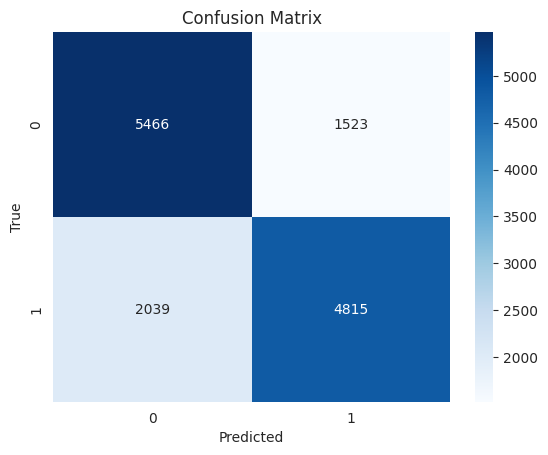

In [56]:
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", xgb_clf)
])

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best parameters found:")
print(search.best_params_)

xgb_tune = search.best_estimator_
evaluate_model(xgb_tune, X_test, y_test)

### 5.2 LightGBM

Accuracy : 0.7373
Precision: 0.7600
Recall   : 0.6895
F1-score : 0.7231

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6957
           1       0.76      0.69      0.72      6886

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.74     13843
weighted avg       0.74      0.74      0.74     13843



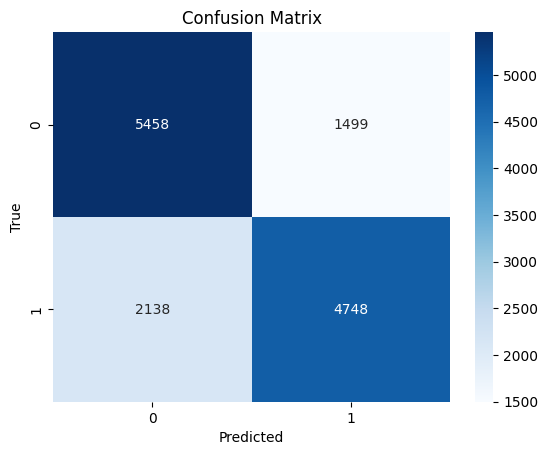

In [26]:
lgbm = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", LGBMClassifier(random_state=42, verbosity=-1))
])

lgbm.fit(X_train, y_train)

evaluate_model(lgbm, X_test, y_test)

Accuracy : 0.7380
Precision: 0.7620
Recall   : 0.6882
F1-score : 0.7232

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      6957
           1       0.76      0.69      0.72      6886

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.74     13843
weighted avg       0.74      0.74      0.74     13843



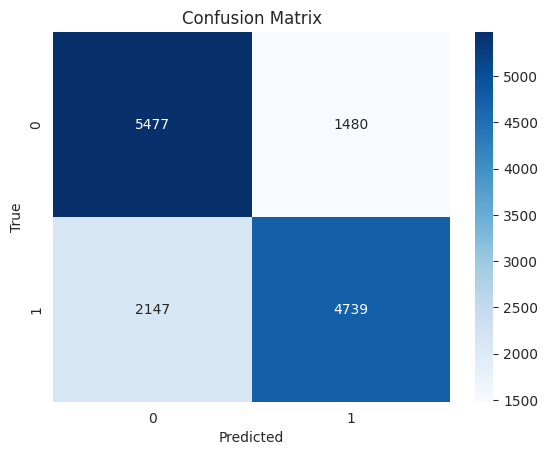

In [44]:
params = {
    'learning_rate': 0.05,
    'max_depth': -1,
    'n_estimators': 100,
    'num_leaves': 50
}
lgbm_clf = LGBMClassifier(**params, random_state=42, verbosity=-1)

lgbm = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", lgbm_clf)
])

lgbm.fit(X_train, y_train)

evaluate_model(lgbm, X_test, y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found:  {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}
Best F1-score on validation:  0.7360979521507007
Accuracy : 0.7358
Precision: 0.7586
Recall   : 0.6876
F1-score : 0.7214

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6957
           1       0.76      0.69      0.72      6886

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.74     13843
weighted avg       0.74      0.74      0.74     13843



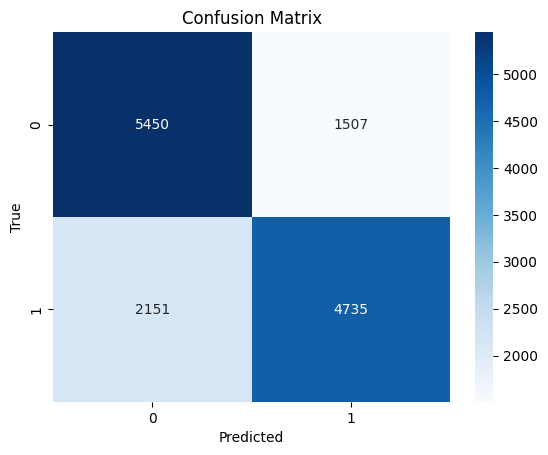

In [29]:
lgbm_clf = LGBMClassifier(random_state=42, verbosity=-1)

pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", lgbm_clf)
])

param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator=lgbm_clf,
    param_grid=param_grid,
    scoring='accuracy',  # hoặc 'accuracy', 'recall', tùy bài toán
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best F1-score on validation: ", grid_search.best_score_)

lgbm_tune = grid_search.best_estimator_
evaluate_model(lgbm_tune, X_test, y_test)

#### LightGBM sau khi tinh chỉnh siêu tham số bằng phương pháp thủ công cho kết quả tốt, nhưng khi áp dụng GridSearchCV thì độ chính xác lại giảm nhẹ, có thể do GridSearchCV dò theo một lưới siêu tham số không tối ưu hoặc bị overfitting trên tập huấn luyện, dẫn đến hiệu suất kém hơn trên dữ liệu kiểm tra.

## 6. SVM

Accuracy : 0.7357
Precision: 0.7659
Recall   : 0.6750
F1-score : 0.7176

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6957
           1       0.77      0.67      0.72      6886

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.73     13843
weighted avg       0.74      0.74      0.73     13843



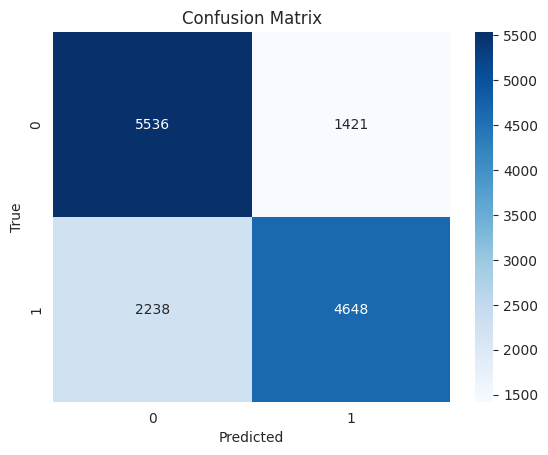

In [47]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('svm', SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced'))
])

svm_pipeline.fit(X_train, y_train)
evaluate_model(svm_pipeline, X_test, y_test)

## 7. MLP

Accuracy : 0.7303
Precision: 0.7496
Recall   : 0.6875
F1-score : 0.7172

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6957
           1       0.75      0.69      0.72      6886

    accuracy                           0.73     13843
   macro avg       0.73      0.73      0.73     13843
weighted avg       0.73      0.73      0.73     13843



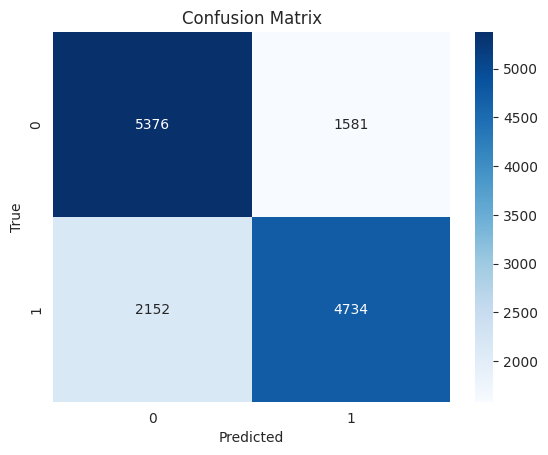

In [48]:
mlp = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("mlp", MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42))
])
mlp.fit(X_train, y_train)
evaluate_model(mlp, X_test, y_test)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train).astype(np.float32)
X_test = preprocessor.fit_transform(X_test).astype(np.float32)
# TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [35]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=X_train.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 21):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Train Loss: {avg_loss:.4f}")

Epoch 1, Train Loss: 0.5689
Epoch 2, Train Loss: 0.5535
Epoch 3, Train Loss: 0.5500
Epoch 4, Train Loss: 0.5484
Epoch 5, Train Loss: 0.5477
Epoch 6, Train Loss: 0.5466
Epoch 7, Train Loss: 0.5462
Epoch 8, Train Loss: 0.5460
Epoch 9, Train Loss: 0.5461
Epoch 10, Train Loss: 0.5455
Epoch 11, Train Loss: 0.5451
Epoch 12, Train Loss: 0.5446
Epoch 13, Train Loss: 0.5445
Epoch 14, Train Loss: 0.5440
Epoch 15, Train Loss: 0.5441
Epoch 16, Train Loss: 0.5434
Epoch 17, Train Loss: 0.5438
Epoch 18, Train Loss: 0.5436
Epoch 19, Train Loss: 0.5441
Epoch 20, Train Loss: 0.5436


Accuracy : 0.7415
Precision: 0.7622
Recall   : 0.6948
F1-score : 0.7269

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75      6989
         1.0       0.76      0.69      0.73      6854

    accuracy                           0.74     13843
   macro avg       0.74      0.74      0.74     13843
weighted avg       0.74      0.74      0.74     13843



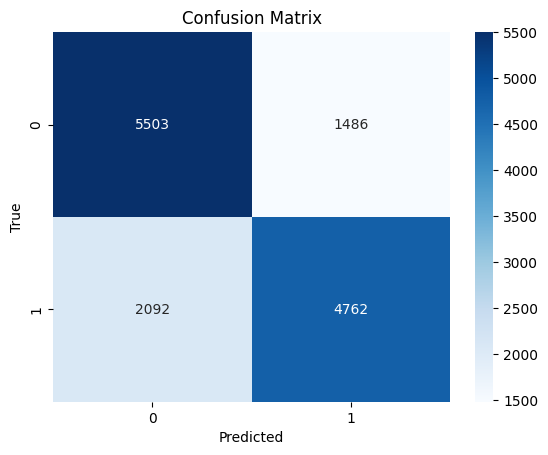

In [45]:
X_test = []
y_test = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        preds = model(xb)
    X_test.append(preds.cpu().numpy())
    y_test.append(yb.cpu().numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

class WrapperModel:
    def __init__(self, raw_preds):
        self.raw_preds = raw_preds

    def predict(self, X):
        return (self.raw_preds > 0.5).astype(int).flatten()

mock_model = WrapperModel(X_test)

evaluate_model(mock_model, X_test, y_test)


# IV. Nhận xét và kết luận

| **Mô hình**           | **Accuracy** | **Precision** | **Recall** | **F1-score** |
|-----------------------|--------------|---------------|------------|--------------|
| Logistic Regression   | 0.7271       | 0.7596        | 0.6650     | 0.7079       |
| *Naive Bayes*         | `0.6855` 🔻  | `0.7417`      | `0.5642` 🔻| `0.6409` 🔻  |
| KNN                   | 0.7311       | 0.7688        | 0.6568     | 0.7084       |
| Decision Tree         | 0.7326       | **0.7882**    | 0.6323     | 0.7017       |
| Random Forest         | 0.7354       | 0.7660        | 0.6740     | 0.7170       |
| **XGBoost**           | **0.7427**   | 0.7597        | **0.7025** | **0.7300**   |
| LightGBM              | 0.7380       | 0.7620        | 0.6882     | 0.7232       |
| SVM                   | 0.7357       | 0.7659        | 0.6750     | 0.7176       |
| MLP                   | 0.7415       | 0.7622        | 0.6948     | 0.7269       |


## 1. Nhận xét

#### Trong tập dữ liệu bệnh tim mạch này, việc sử dụng phương pháp clip outliers được đánh giá là hiệu quả hơn so với loại bỏ outliers bằng IQR, vì một số lý do sau:

- Giữ lại nhiều dữ liệu hơn: Dữ liệu y tế thường đã bị mất cân đối (class imbalance), nếu tiếp tục loại bỏ các dòng chứa outlier thì sẽ càng làm giảm lượng mẫu huấn luyện, dễ gây thiếu thông tin và giảm hiệu suất mô hình.

- Một số outlier là hợp lý về mặt y khoa: Ví dụ, người có cân nặng 180kg hoặc huyết áp 250/150 là hiếm nhưng vẫn có thể xuất hiện trong thực tế. Nếu dùng IQR thì các trường hợp đặc biệt này sẽ bị loại bỏ không cần thiết.

- Giảm rủi ro sai lệch phân bố: Thay vì xóa hoàn toàn dòng, clip chỉ điều chỉnh giá trị vượt ngưỡng về một giá trị tối đa/tối thiểu hợp lý, giúp bảo toàn cấu trúc dữ liệu và phân bố.

- Kết hợp với kiểm tra logic (ví dụ ap_hi > ap_lo), phương pháp này còn giúp phát hiện và xử lý lỗi nhập liệu sai – điều mà IQR không thể phát hiện.

Vì vậy, trong bối cảnh dữ liệu y tế nhạy cảm và không dư thừa, phương pháp clip nhẹ nhàng và an toàn hơn, giúp giữ lại nhiều thông tin quan trọng cho mô hình học máy.


#### Sau quá trình huấn luyện và đánh giá trên tập dữ liệu về bệnh tim mạch, nhóm đã tổng hợp kết quả thực nghiệm của các mô hình học máy phổ biến. Bảng kết quả cho thấy sự khác biệt rõ rệt giữa các nhóm thuật toán, đặc biệt khi xét trên các chỉ số đánh giá như Accuracy, Precision, Recall và F1-score.

Một số nhận xét đáng chú ý:

🔹 XGBoost là mô hình có hiệu suất tốt nhất, với:

- Accuracy: 0.7427

- Recall: 0.7025

- F1-score: 0.7300

Điều này cho thấy XGBoost không chỉ đoán đúng nhiều mẫu (Accuracy cao) mà còn đặc biệt giỏi trong việc phát hiện bệnh (Recall cao), đồng thời duy trì sự cân bằng tổng thể tốt (F1-score cao). Đây là mô hình phù hợp nhất trong bối cảnh y tế, nơi việc giảm thiểu bỏ sót ca bệnh là rất quan trọng.

🔹 MLP (Multi-layer Perceptron) và LightGBM cũng có hiệu năng rất cạnh tranh, với F1-score lần lượt là 0.7269 và 0.7232, gần sát với XGBoost. Điều này cho thấy mô hình mạng nơron sâu và Boosting đều phù hợp với dữ liệu dạng bảng trong y học.

🔹 Decision Tree đạt Precision cao nhất (0.7882), tuy nhiên Recall lại thấp hơn, cho thấy mô hình này thận trọng hơn nhưng có xu hướng bỏ sót một số ca bệnh.

🔹 Naive Bayes là mô hình yếu nhất trong số các thuật toán thử nghiệm:

   - Accuracy: 0.6855

   - Recall: 0.5642

   - F1-score: 0.6409

Nguyên nhân chính là giả định độc lập giữa các đặc trưng không phù hợp với dữ liệu y tế thực tế – nơi các đặc trưng như huyết áp, chỉ số cơ thể và tuổi tác có liên hệ chặt chẽ.

## 2.  Kết luận
Dự án này là một minh chứng cụ thể cho quy trình xây dựng một hệ thống dự đoán bệnh tim mạch từ dữ liệu thực tế. Nhóm đã triển khai đầy đủ các bước chính trong một pipeline học máy, bao gồm:

- Tiền xử lý dữ liệu:

  - Tạo biến mới age_years và BMI để tăng khả năng biểu diễn thông tin.
  - Loại bỏ outlier bằng kỹ thuật clip() theo ngưỡng y tế thực tế, giúp mô hình học hiệu quả hơn so với kỹ thuật IQR thông thường.
  - Chuẩn hóa dữ liệu số.

- Huấn luyện đa dạng mô hình: Logistic Regression, Naive Bayes, K-Nearest Neighbors, Decision Tree, Random Forest, SVM, MLP, XGBoost, LightGBM.

- Đánh giá mô hình toàn diện bằng các chỉ số Accuracy, Precision, Recall, F1-score giúp cân đối giữa độ chính xác và khả năng phát hiện bệnh.

🔹Vậy XGBoost là mô hình có hiệu suất tốt nhất, dẫn đầu ở cả 3 chỉ số chính: Accuracy, Recall, F1-score. Điều này cho thấy XGBoost không chỉ đoán đúng nhiều mẫu bệnh (Accuracy cao), mà còn có khả năng phát hiện đúng bệnh nhân (Recall cao), đồng thời duy trì sự cân bằng tốt giữa Precision và Recall (F1-score cao). Trong lĩnh vực y tế, đây là yếu tố quan trọng, vì việc bỏ sót ca bệnh có thể dẫn tới hậu quả nghiêm trọng.

🔹MLP và LightGBM cũng là các lựa chọn mạnh mẽ, chứng minh tiềm năng của học sâu và Boosting trên dữ liệu bảng.

🔹 Ngoài ra, Decision Tree đạt Precision cao nhất, tức là khi mô hình này dự đoán một bệnh nhân bị tim mạch, thì khả năng đúng của dự đoán đó là rất cao. Điều này có giá trị trong các tình huống cần giảm thiểu chẩn đoán nhầm người không bệnh thành có bệnh (giảm false positives).

Kết quả này mở ra tiềm năng lớn cho việc ứng dụng các mô hình học máy tiên tiến vào hỗ trợ chẩn đoán bệnh trong thực tế.

## 3.  Định hướng phát triển

Nhằm cải thiện chất lượng mô hình và mở rộng khả năng ứng dụng thực tế, nhóm đề xuất một số hướng phát triển trong tương lai:

- Tối ưu MLP: Nghiên cứu các kiến trúc sâu hơn (deep MLP), áp dụng kỹ thuật dropout, batch normalization, weight decay, và early stopping để nâng cao khả năng khái quát và giảm overfitting.

- Khám phá các mô hình tiên tiến: Triển khai thử nghiệm các mô hình thiết kế riêng cho dữ liệu bảng như TabNet hoặc TabTransformer – đây là các mô hình học sâu mới có khả năng tự động học tương tác giữa các đặc trưng mà không cần tiền xử lý thủ công.

- Phát triển giao diện người dùng: Xây dựng ứng dụng dự đoán bệnh tim mạch bằng Streamlit hoặc Gradio, giúp người dùng đầu cuối dễ dàng nhập thông tin sức khỏe và nhận kết quả chẩn đoán một cách trực quan, thân thiện.

- Thử nghiệm trên dữ liệu thực: Mở rộng thử nghiệm trên các tập dữ liệu y tế khác, thậm chí có thể hợp tác với cơ sở y tế để kiểm chứng mô hình trên dữ liệu thực tế, từ đó đánh giá độ tin cậy và khả năng triển khai trong môi trường lâm sàng.



## 4. Bài học
Thông qua quá trình triển khai dự án, nhóm đã có cơ hội áp dụng một cách hệ thống kiến thức học máy để giải quyết một bài toán thực tế trong lĩnh vực y tế, dự đoán nguy cơ mắc bệnh tim mạch từ dữ liệu lâm sàng. Cụ thể, nhóm đã rút ra được nhiều bài học quan trọng trong quá trình xây dựng và đánh giá các mô hình:

- Tư duy thử nghiệm mô hình một cách khoa học: Nhóm không chỉ thử một mô hình duy nhất, mà đã triển khai và so sánh hiệu suất của nhiều thuật toán khác nhau như:
Logistic Regression, Naive Bayes, K-Nearest Neighbors, Decision Tree, Random Forest, SVM, MLP, XGBoost và LightGBM.
Việc này giúp nhóm hiểu sâu hơn về ưu nhược điểm của từng loại mô hình trong bối cảnh dữ liệu thực tế.
  
- Hiểu rõ mối quan hệ giữa các chỉ số đánh giá: Qua việc sử dụng các chỉ số như accuracy, precision, recall và F1-score, nhóm học được cách đánh giá mô hình một cách toàn diện thay vì chỉ dựa vào độ chính xác. Đặc biệt trong dữ liệu y tế, recall thường được ưu tiên để tránh bỏ sót các ca bệnh thật.

- Tối ưu và tinh chỉnh mô hình: Nhóm đã thực hành điều chỉnh siêu tham số cho các mô hình như KNN (chọn K tối ưu), Decision Tree, Random Forest, XGBoost và LightGBM thông qua kỹ thuật tìm kiếm lưới (GridSearchCV) và tối ưu ngẫu nhiên (RandomizedSearchCV). Điều này giúp cải thiện hiệu suất và hiểu rõ hơn ảnh hưởng của từng siêu tham số.

- Hiểu sâu hơn về các mô hình phức tạp như MLP và XGBoost: Việc triển khai MLP giúp nhóm làm quen với khái niệm mạng học sâu, cách huấn luyện qua nhiều epoch và điều chỉnh trọng số theo từng batch. Tuy nhiên, chính XGBoost mới là mô hình cho kết quả tốt nhất (Accuracy = 0.7467), chứng minh hiệu quả của các thuật toán boosting hiện đại trong việc xử lý dữ liệu structured/tabular như trong bài toán này.

- Biết cách lựa chọn mô hình phù hợp với bài toán: Dựa vào kết quả đánh giá và phân tích dữ liệu, nhóm đã rút ra được rằng không phải mô hình phức tạp nhất luôn là mô hình tốt nhất — mà mô hình phù hợp còn tùy thuộc vào đặc trưng dữ liệu, yêu cầu bài toán (ví dụ: ưu tiên recall), và khả năng triển khai thực tế.

#

### Những lỗi từng gặp phải và cách xử lý.

Trong quá trình thực hiện dự án, nhóm đã gặp phải nhiều vấn đề phát sinh từ dữ liệu thực tế cũng như trong quá trình xử lý và mô hình hóa. Dưới đây là tổng hợp các lỗi điển hình và cách nhóm đã xử lý chúng:

#### 1. Giá trị bất thường ở cột huyết áp

- Vấn đề: Xuất hiện nhiều giá trị không hợp lý như ap_hi > 1000 hoặc ap_lo âm.

- Nguyên nhân: Lỗi nhập liệu hoặc ghi nhầm đơn vị.

- Cách xử lý: Dùng thống kê mô tả và biểu đồ phân phối để phát hiện; sau đó clip lại trong khoảng hợp lý (ap_hi: 60–250, ap_lo: 40–150) và loại bỏ các dòng có logic sai (ap_hi < ap_lo).


#### 2. Outlier nghiêm trọng ở chiều cao và cân nặng

- Vấn đề: Một số giá trị height và weight ban đầu vượt xa giới hạn thực tế (ví dụ: người cao 80 cm hoặc nặng 250 kg), gây ảnh hưởng đến các chỉ số phân tích và mô hình hóa.

- Nguyên nhân: Lỗi nhập dữ liệu hoặc không có bước kiểm soát chất lượng đầu vào trong quá trình thu thập.

- Cách xử lý: Nhóm sử dụng biểu đồ boxplot và histogram để xác định các outlier, sau đó áp dụng hàm clip() để giới hạn dữ liệu trong khoảng hợp lý (height: 100–220 cm, weight: 30–180 kg). Sau bước này, nhóm tính thêm các đặc trưng mới là age_years và BMI (Body Mass Index), rồi loại bỏ các cột gốc age, height và weight để tránh trùng lặp thông tin và tăng tính trực quan trong mô hình hóa.


#### 3. Dữ liệu bị lệch phân bố ở nhiều cột

- Vấn đề: Một số biến như alco, smoke có hơn 90% giá trị là 0 → mất cân bằng nghiêm trọng.

- Nguyên nhân: Đặc điểm tự nhiên của hành vi sức khỏe trong tập dữ liệu.

- Cách xử lý: Nhận xét và ghi chú rõ trong phần EDA. Hiện tại chưa xử lý mà để dành cho bước xử lý mất cân bằng ở các hướng phát triển sau.




### 6. Phụ lục

- **Link dataset gốc**: [https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)

- **Tài liệu tham khảo**:
  - Pandas Documentation: https://pandas.pydata.org/docs/
  - Matplotlib Documentation: https://matplotlib.org/stable/contents.html
  - Seaborn Documentation: https://seaborn.pydata.org/
  - Scikit-learn Documentation: https://scikit-learn.org/stable/
  - XGBoost Docs: https://xgboost.readthedocs.io/en/stable/
  - LightGBM Docs: https://lightgbm.readthedocs.io/en/latest/
  - Slide và hướng dẫn môn học *Python for Machine Learning* (PTIT, 2025)